In this notebook, we show some supporting functions for reading, visualizing the training and testing data. And, we give a demo on how to use the provided supporting functions to predict the labels for each motor and produce outputs in the required format for the data challenge submission. Finally, we show a demo on how to prepare the submission file based on the provided csv template.

## Reading the data.

As we shown in WP_1, we can use the `read_all_tst_data_from_path` function to read and visualize data. Please note you have the option to define the preprocessing you would like to do on the original data. For this, you just need to define your preprocessing function and pass its function handle to the `read_all_tst_data_from_path` function.

Below is a sample code that reads and visualize all the training dataset, where we apply a simple outlier removal based on validity range as pre-processing. We also remove sequence-to-sequence variablity in the pre-processing. Please note that you need to download the datasets `training_data.zip` and `testing_data.zip` from [kaggle](https://www.kaggle.com/competitions/robot-predictive-maintenance/data) and unzip them. You need to change the path in the sample code below to the path of your datasets.

### Training data.

In [1]:
utility_path = '../'
import sys
sys.path.insert(1, utility_path)

from utility import read_all_test_data_from_path
import numpy as np 
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
%matplotlib inline

# Subfunction for data preprocessing.
def pre_processing(df: pd.DataFrame):
    ''' ### Description
    Preprocess the data:
    - remove outliers
    - add new features about the difference between the current and previous n data point.
    '''
    
    def remove_outliers(df: pd.DataFrame):
        ''' # Description
        Remove outliers from the dataframe based on defined valid ranges. 
        Define a valid range of temperature and voltage. 
        Use ffil function to replace the invalid measurement with the previous value.
        '''
        df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
        df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
        df['temperature'] = df['temperature'].ffill()        

        df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
        df['voltage'] = df['voltage'].where(df['voltage'] <= 9000, np.nan)
        df['voltage'] = df['voltage'].ffill()        

        df['position'] = df['position'].where(df['position'] >= 0, np.nan)
        df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
        df['position'] = df['position'].ffill()


    def remove_seq_variability(df: pd.DataFrame):
        ''' # Description
        Remove the sequence-to-sequence variability.
        '''
        # Tranform the features relative to the first data point.
        df['temperature'] = df['temperature'] - df['temperature'].iloc[0]
        df['voltage'] = df['voltage'] - df['voltage'].iloc[0]
        df['position'] = df['position'] - df['position'].iloc[0]
        
    # Start processing.
    remove_outliers(df)
    remove_seq_variability(df)

20240105_164214: 0    Not moving
Name: Description, dtype: object



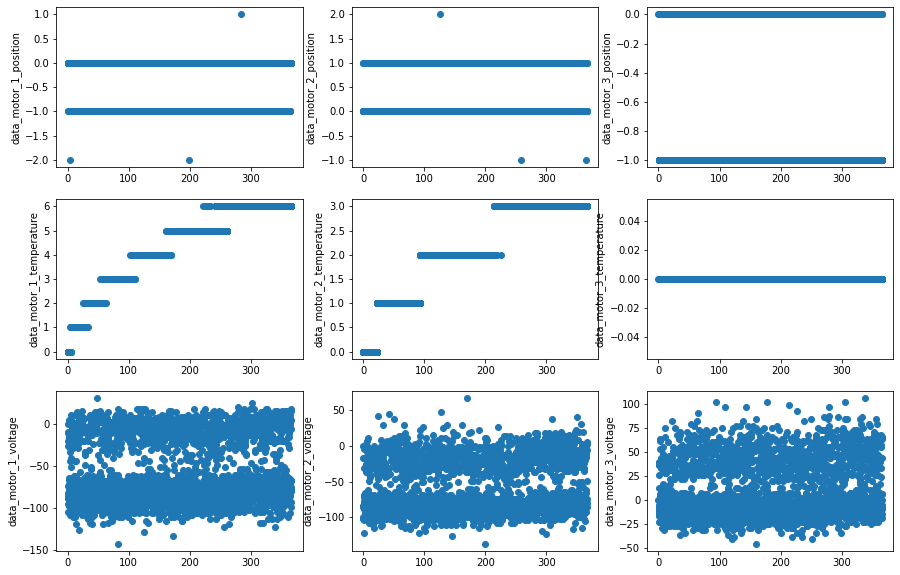

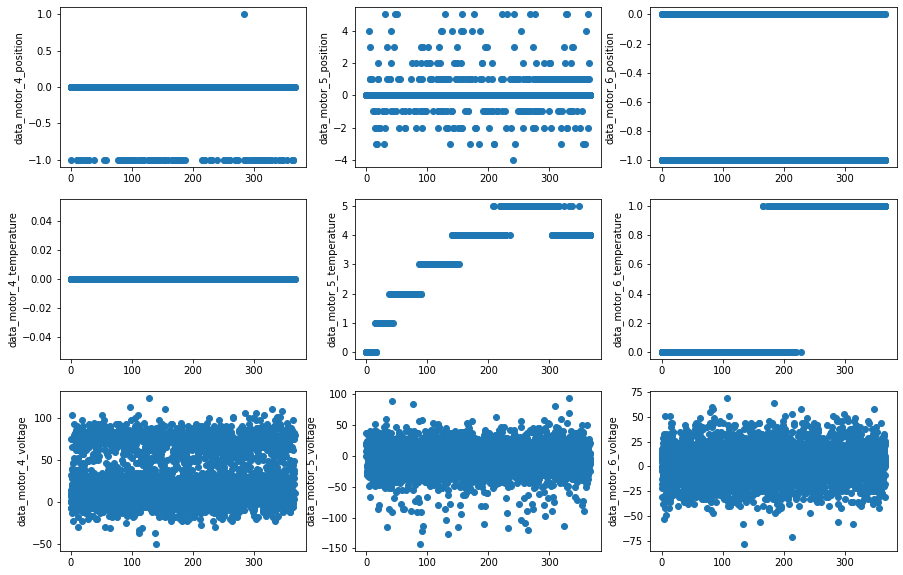

20240105_165300: 1    Pick up and place
Name: Description, dtype: object



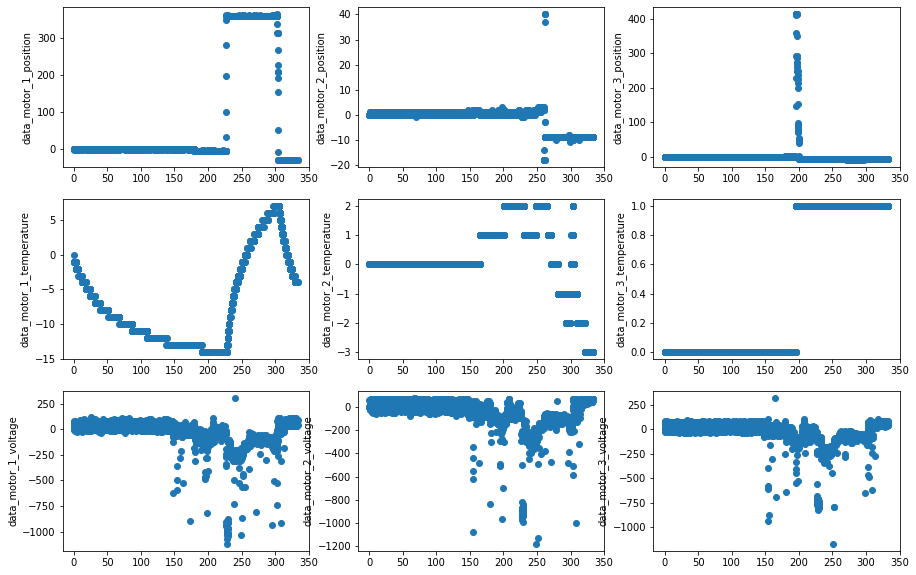

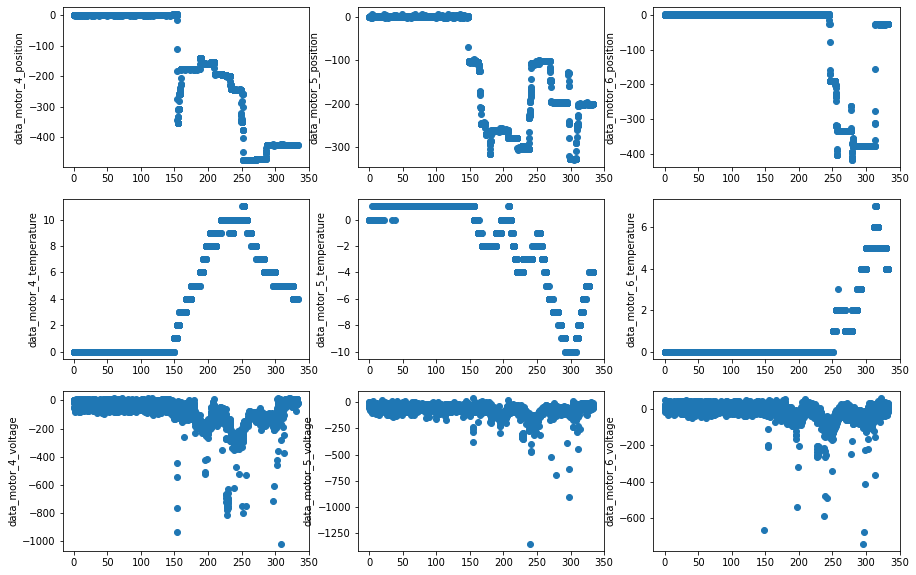

20240105_165972: 2    Not moving
Name: Description, dtype: object



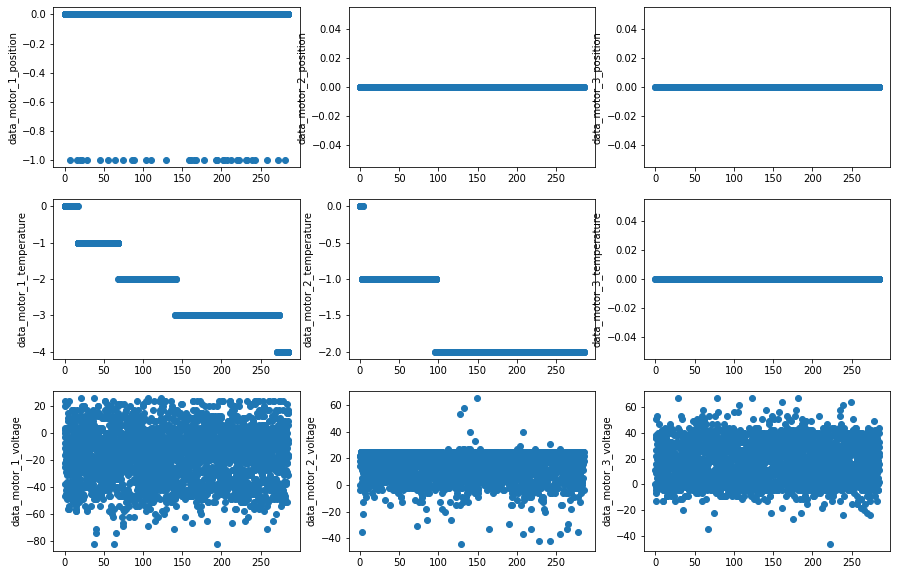

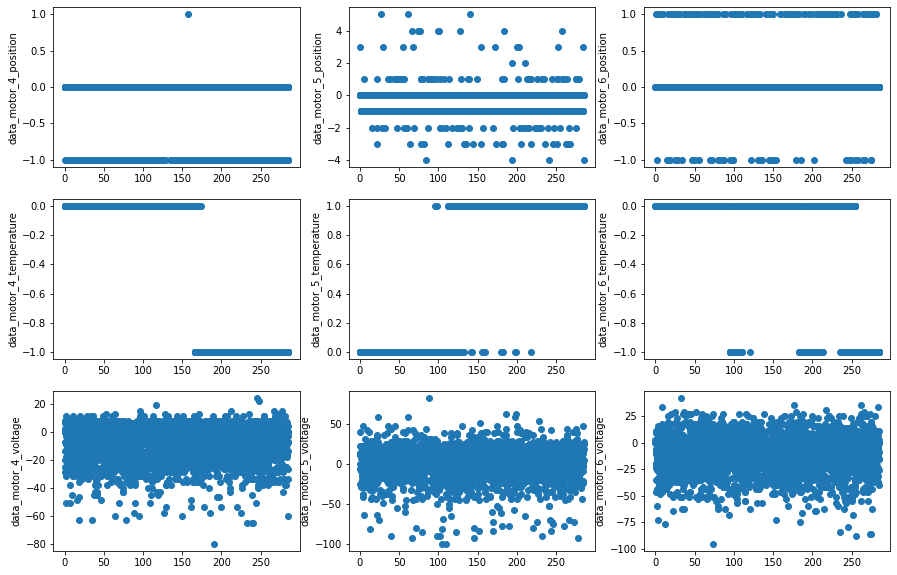

20240320_152031: 3    Not moving
Name: Description, dtype: object



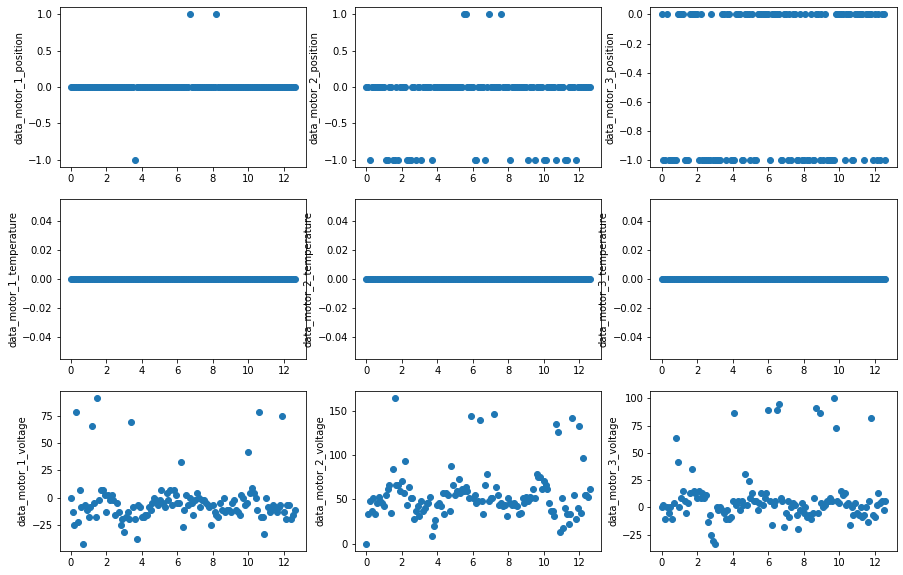

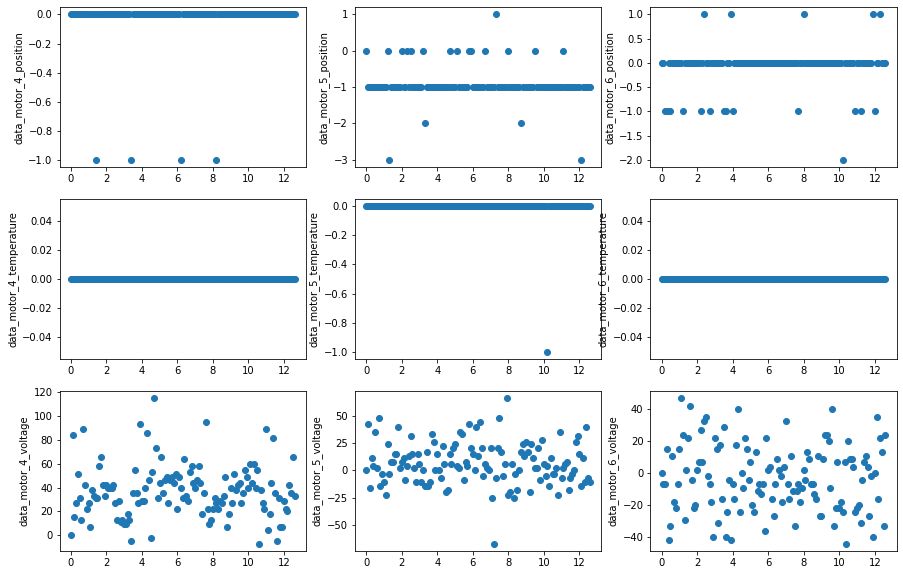

20240320_153841: 4    Move motor 6 -> motor 1 sequentially.
Name: Description, dtype: object



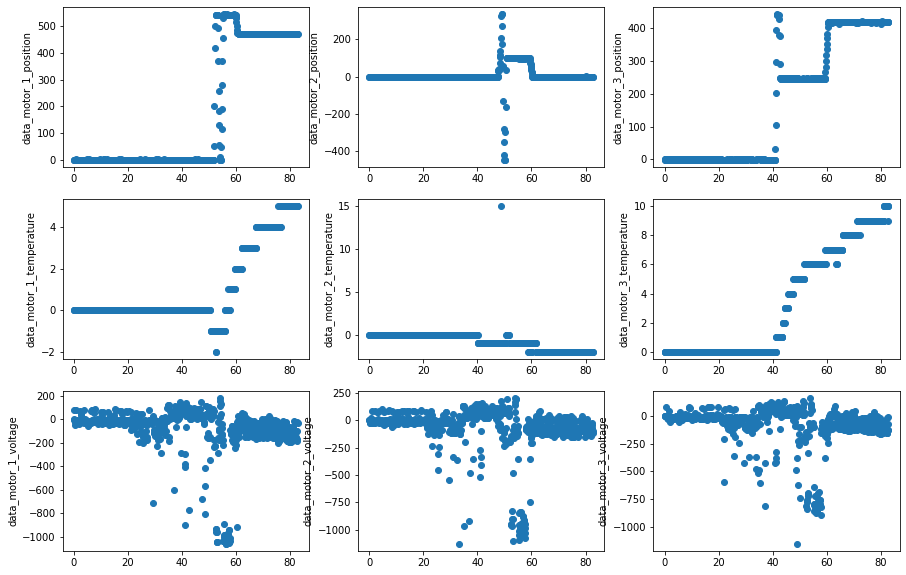

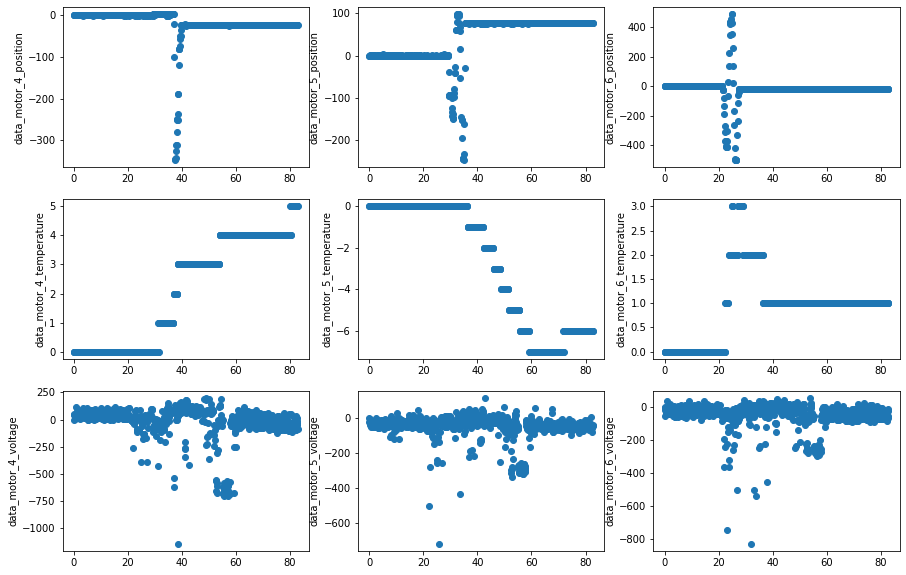

20240320_155664: 5    Not moving
Name: Description, dtype: object



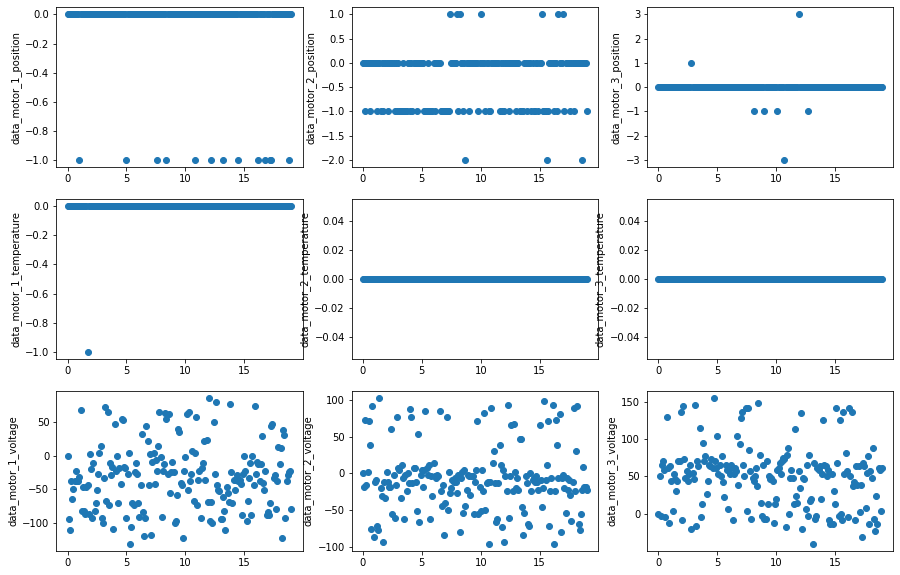

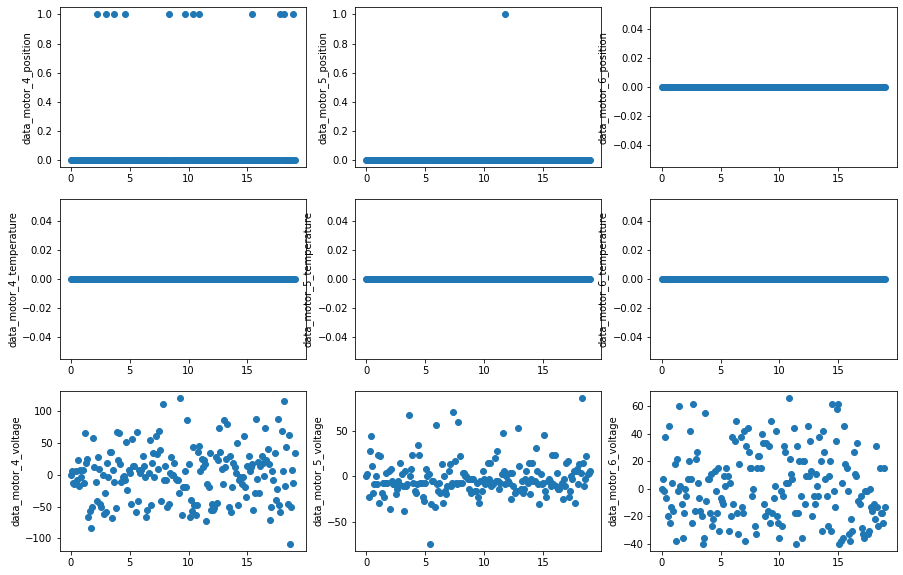

20240321_122650: 6    Pick up and place
Name: Description, dtype: object



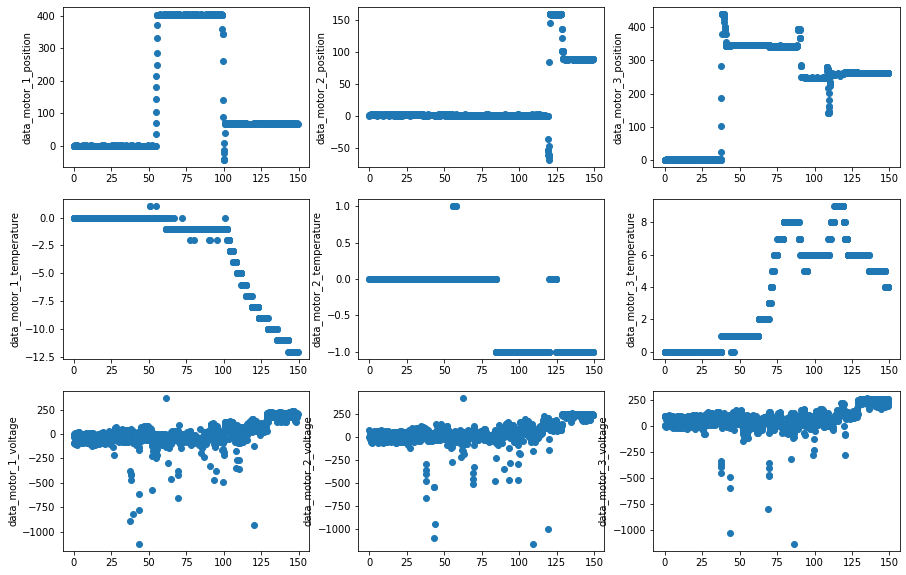

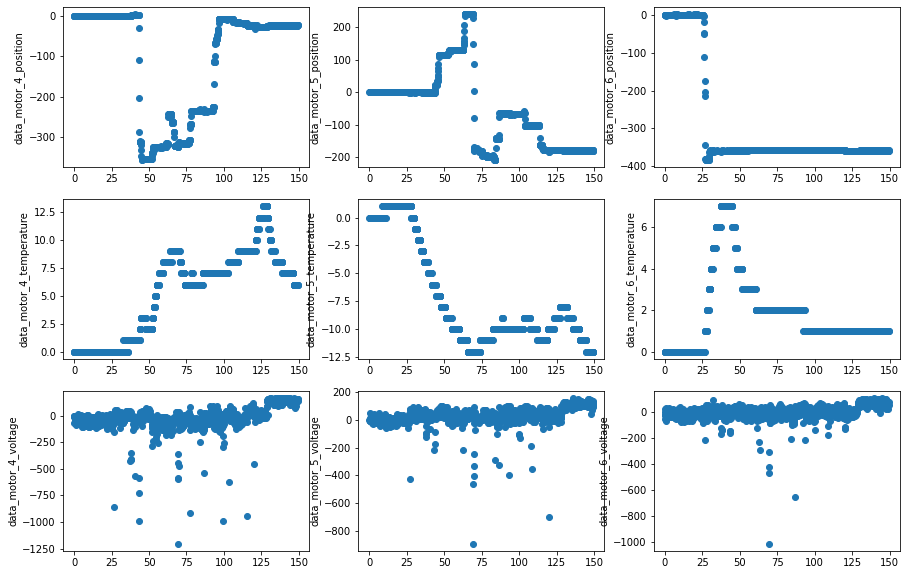

20240325_135213: 7    Not moving
Name: Description, dtype: object



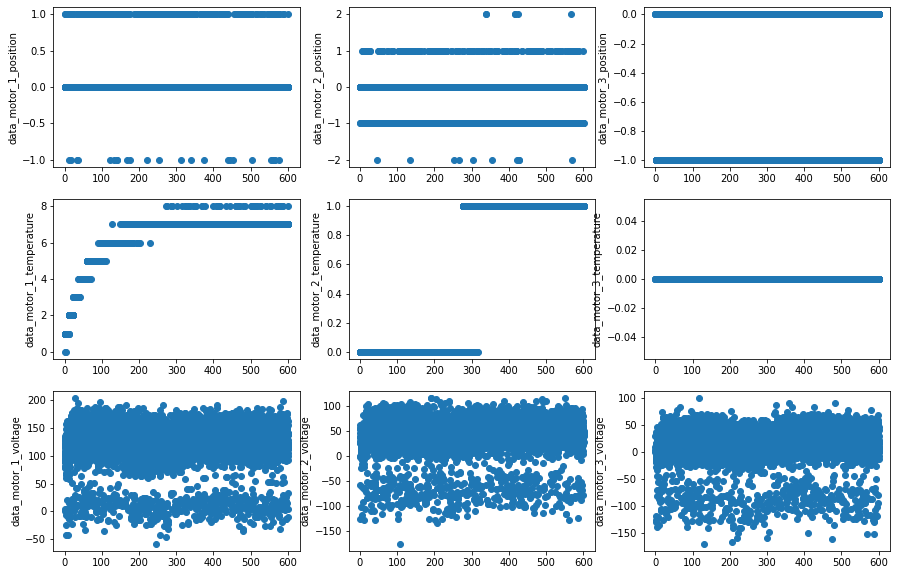

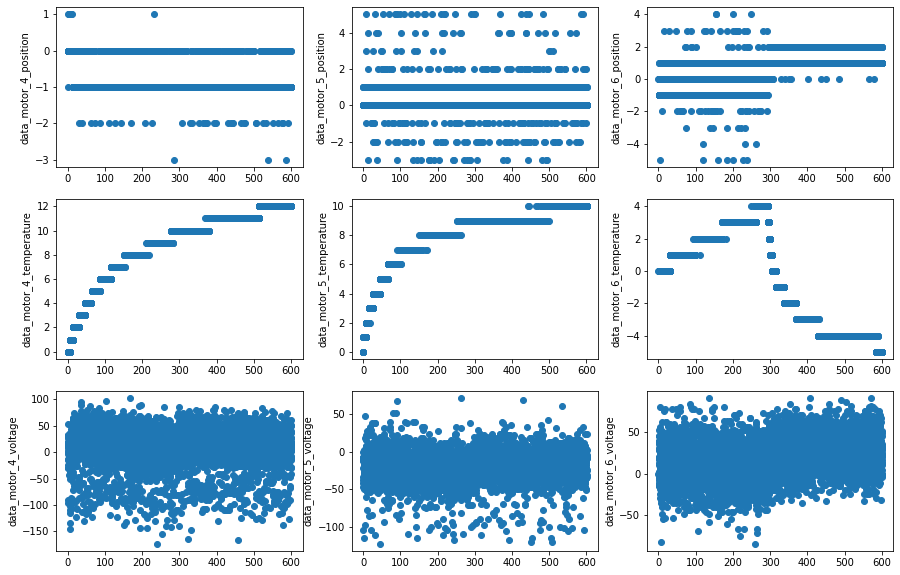

20240325_152902: 8    Pick up and place
Name: Description, dtype: object



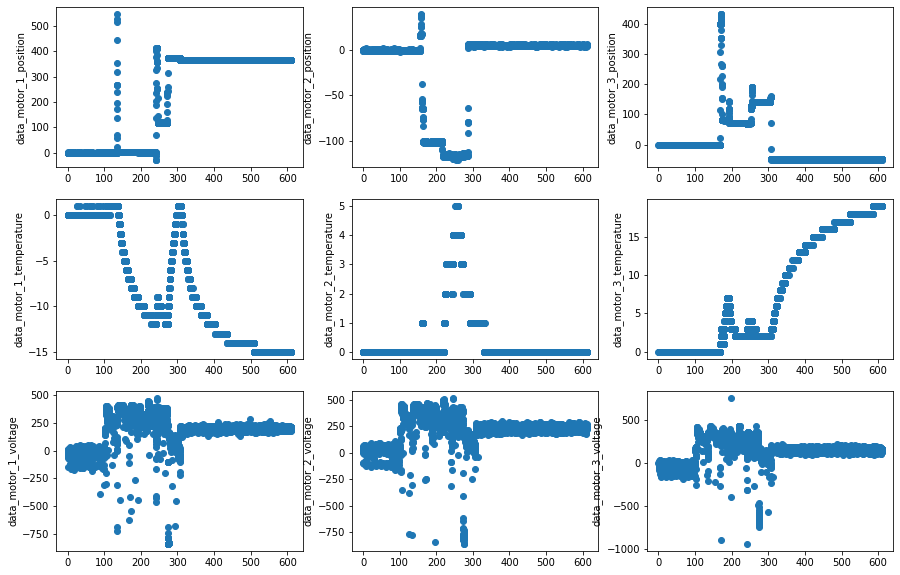

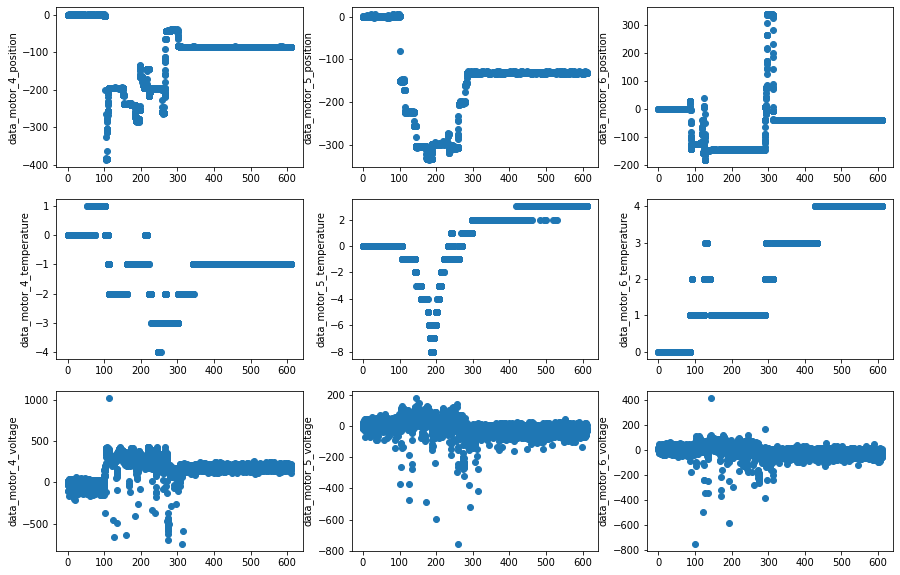

20240325_155003: 9    Pick up and place
Name: Description, dtype: object



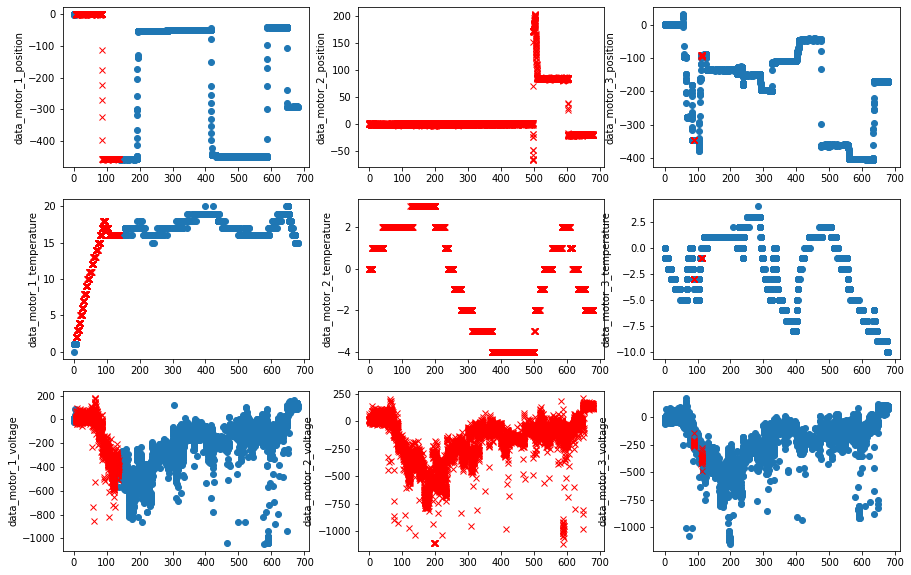

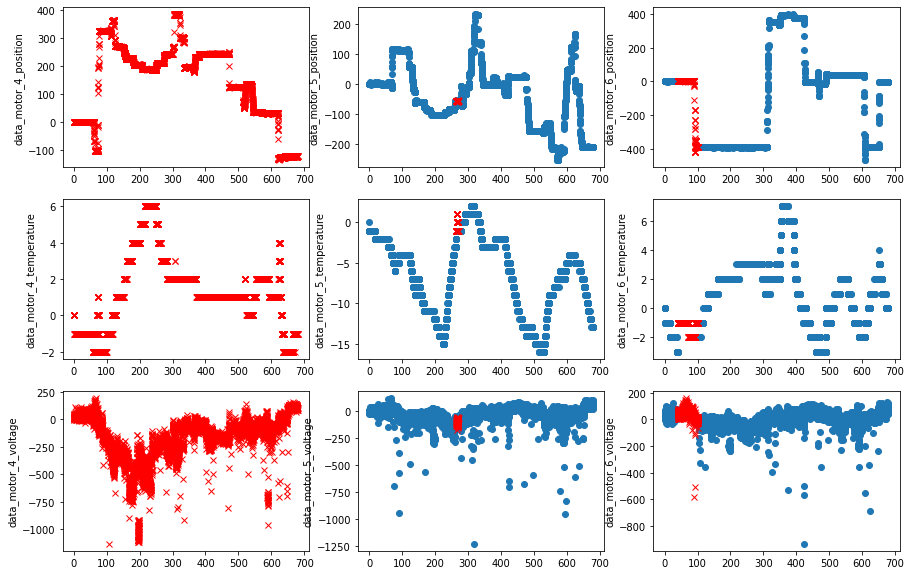

20240425_093699: 10    Not moving
Name: Description, dtype: object



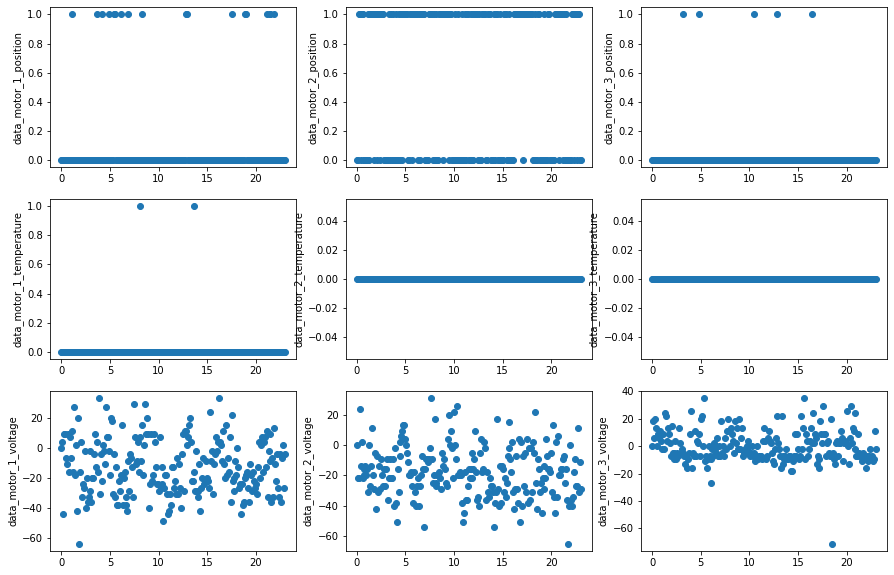

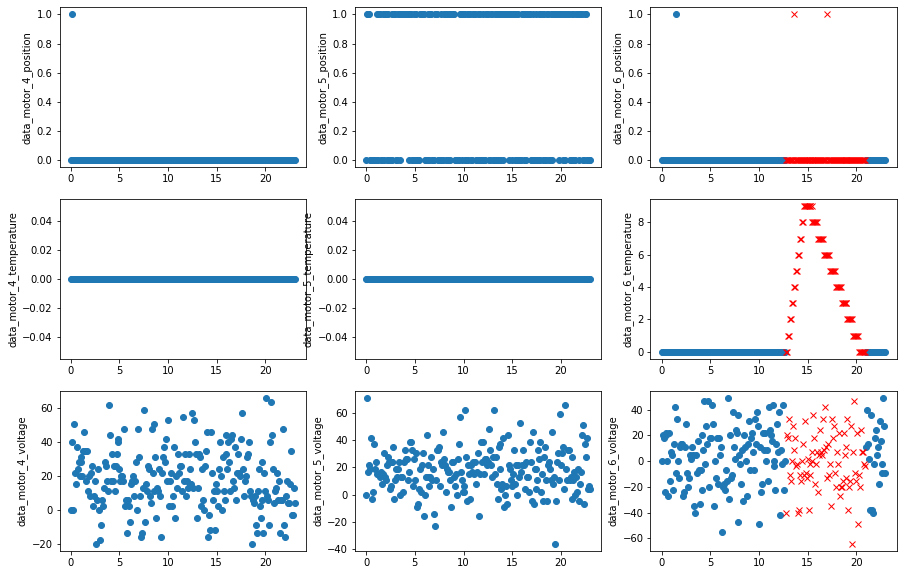

20240425_094425: 11    Not moving
Name: Description, dtype: object



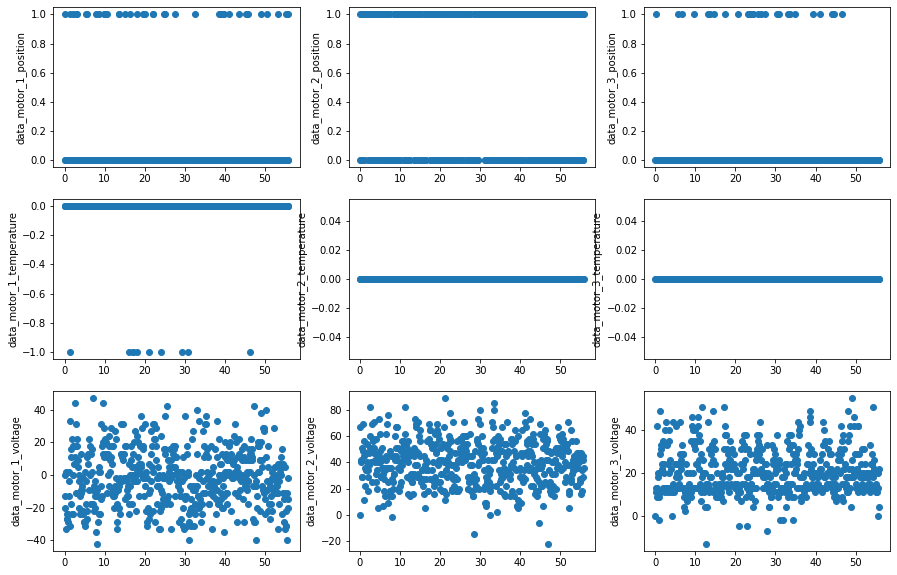

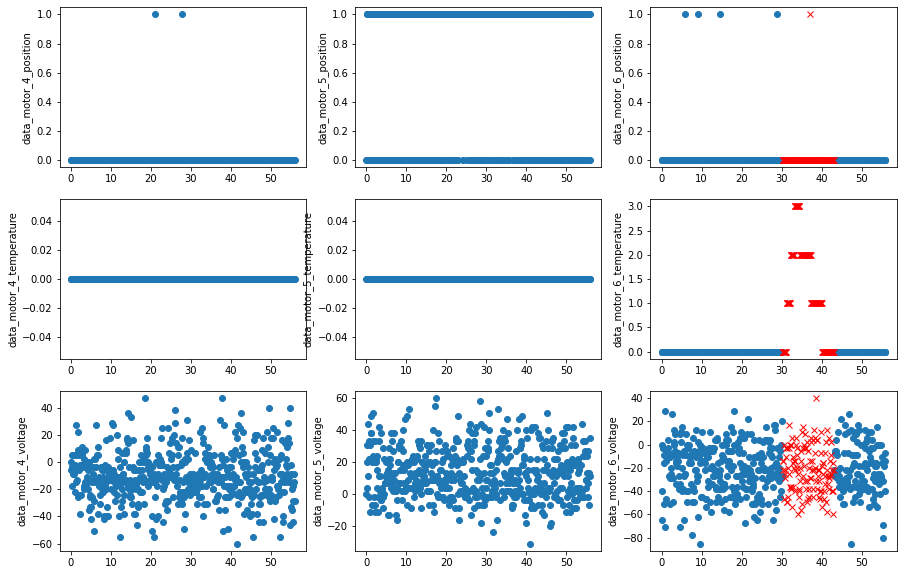

20240426_140055: 12    Not moving
Name: Description, dtype: object



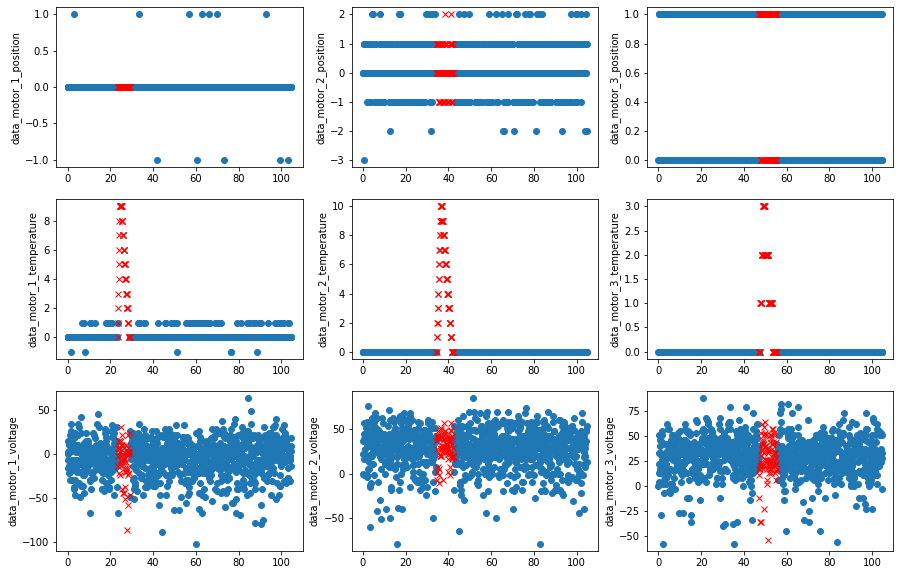

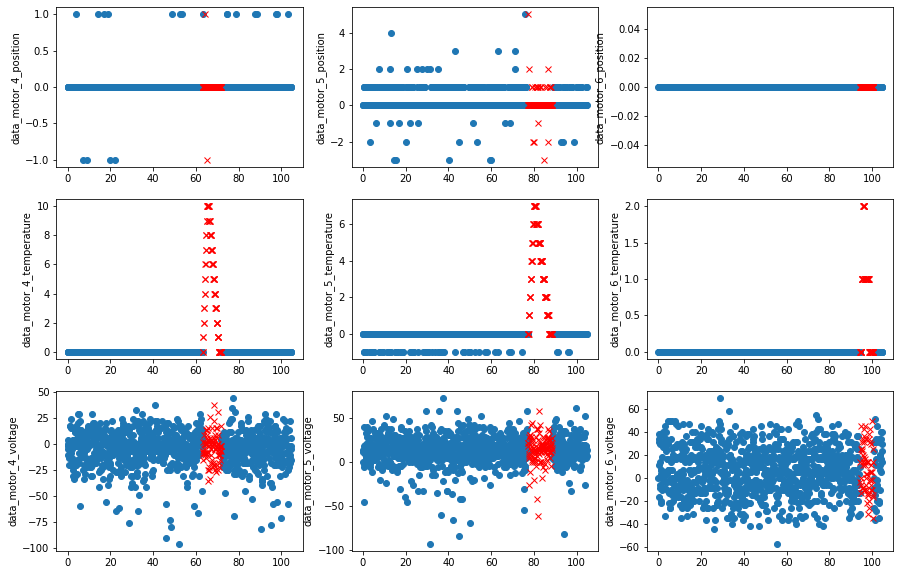

20240426_141190: 13    Pick up and place
Name: Description, dtype: object



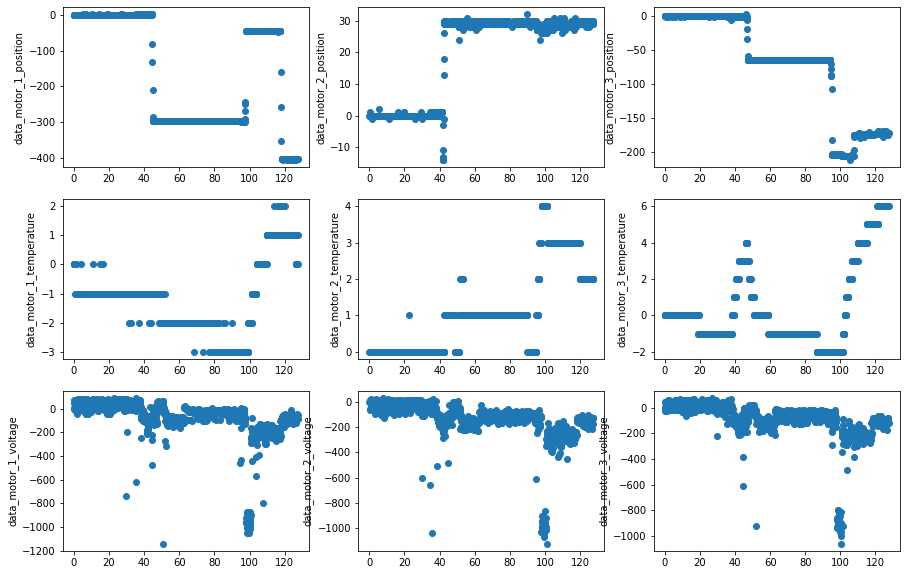

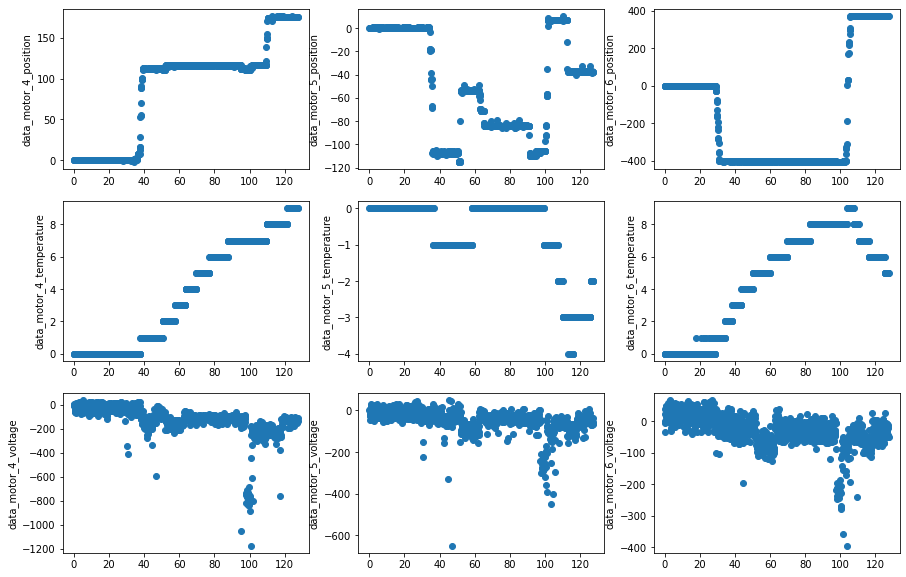

20240426_141532: 14    Moving one motor
Name: Description, dtype: object



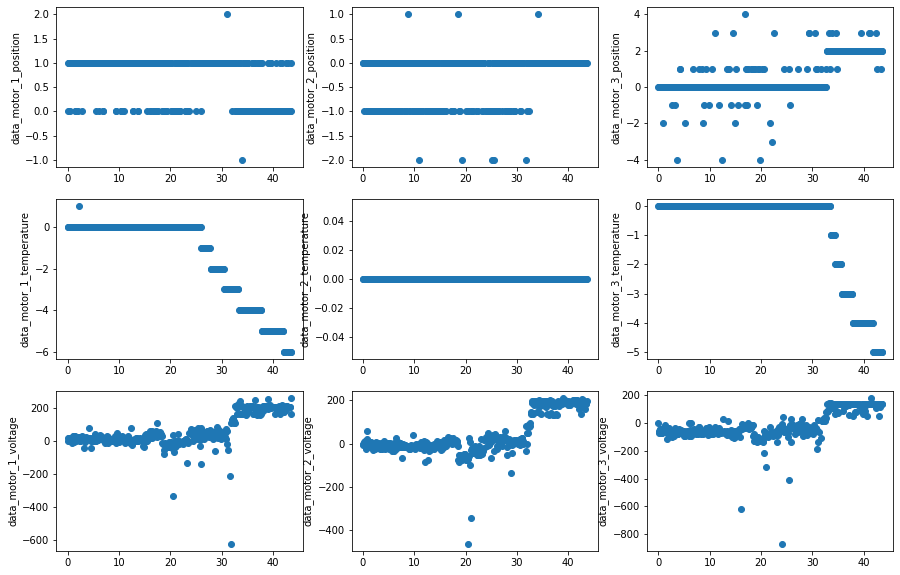

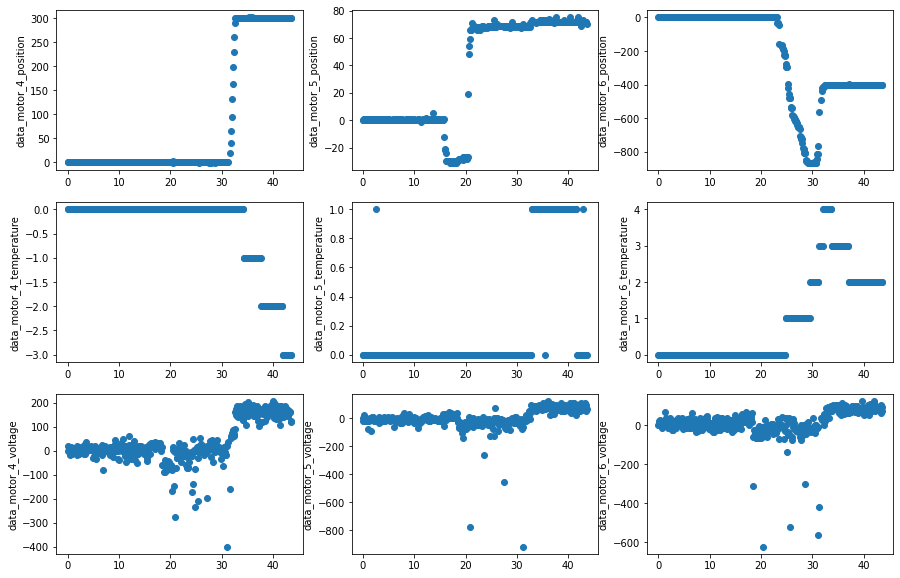

20240426_141602: 15    Moving one motor
Name: Description, dtype: object



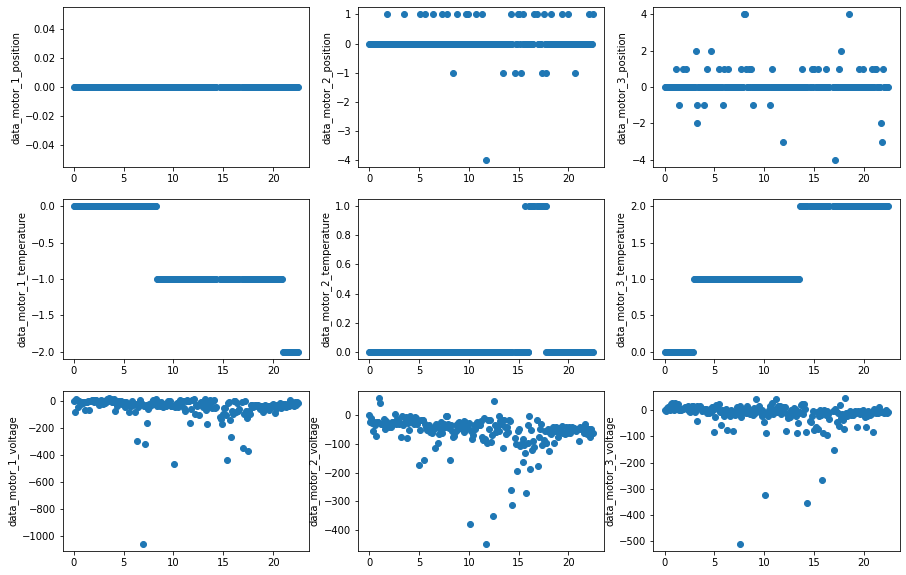

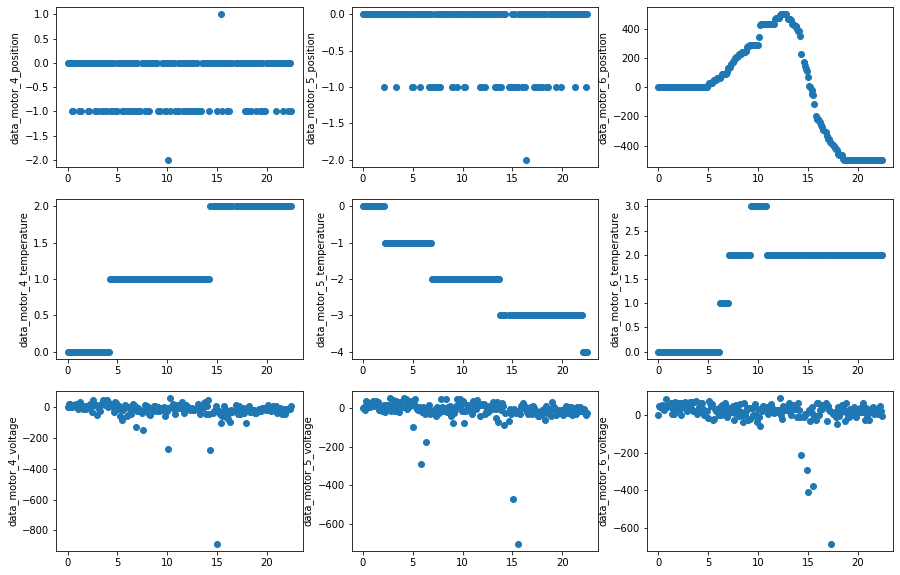

20240426_141726: 16    Moving one motor
Name: Description, dtype: object



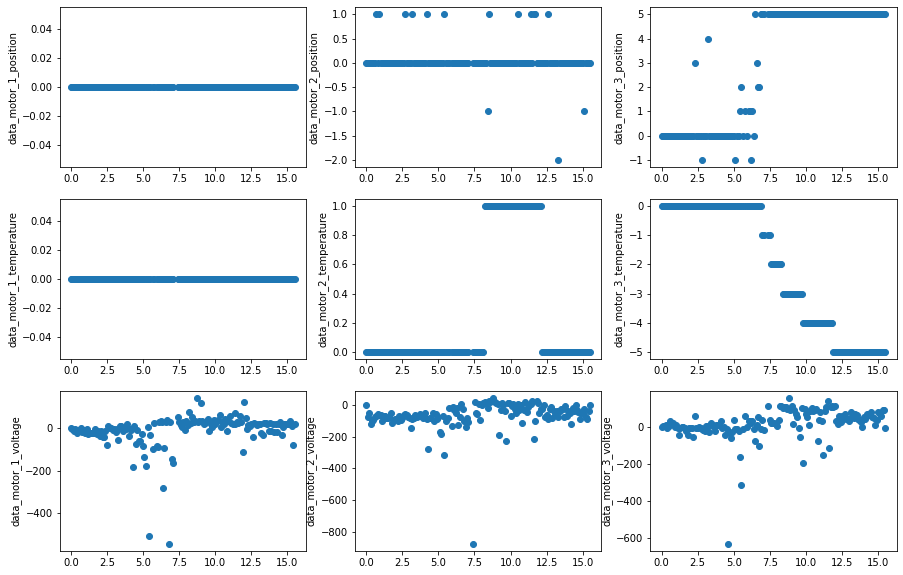

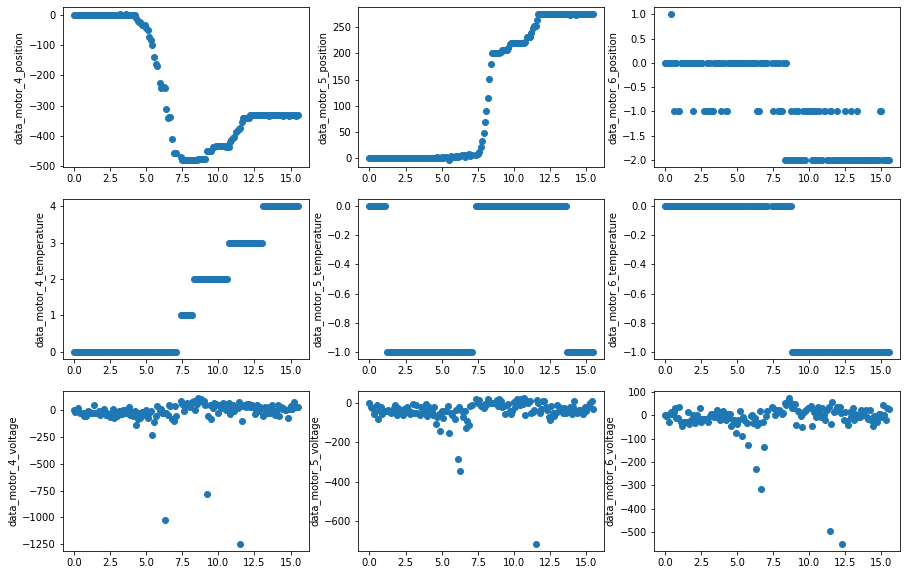

20240426_141938: 17    Moving one motor
Name: Description, dtype: object



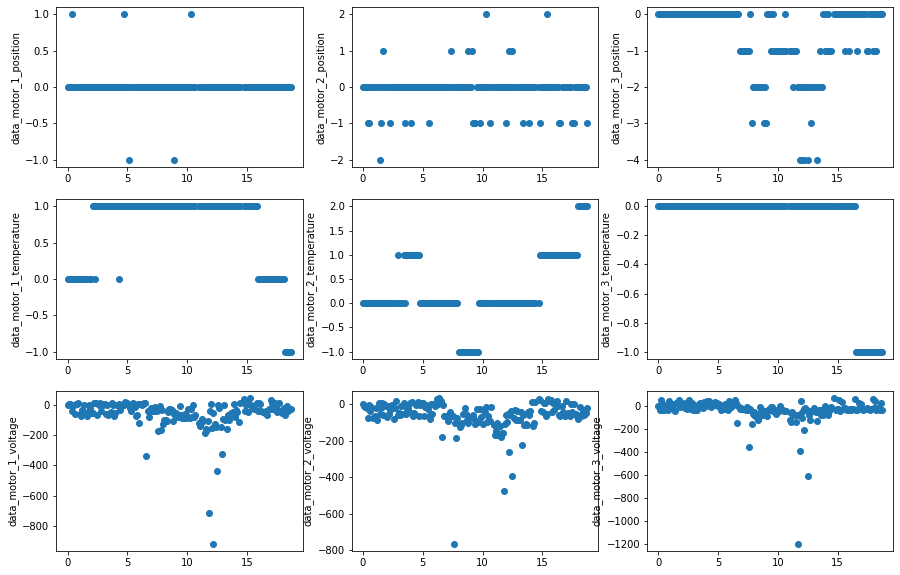

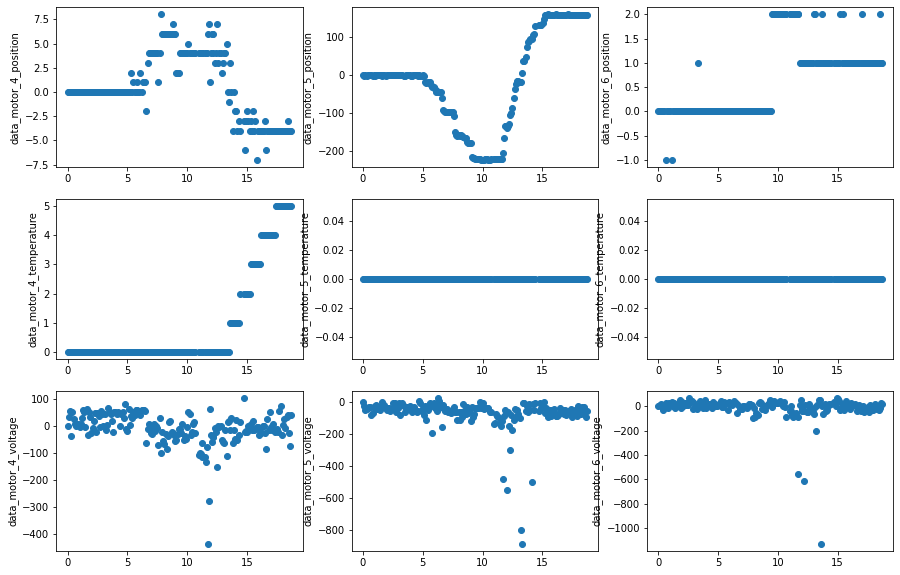

20240426_141980: 18    Moving one motor
Name: Description, dtype: object



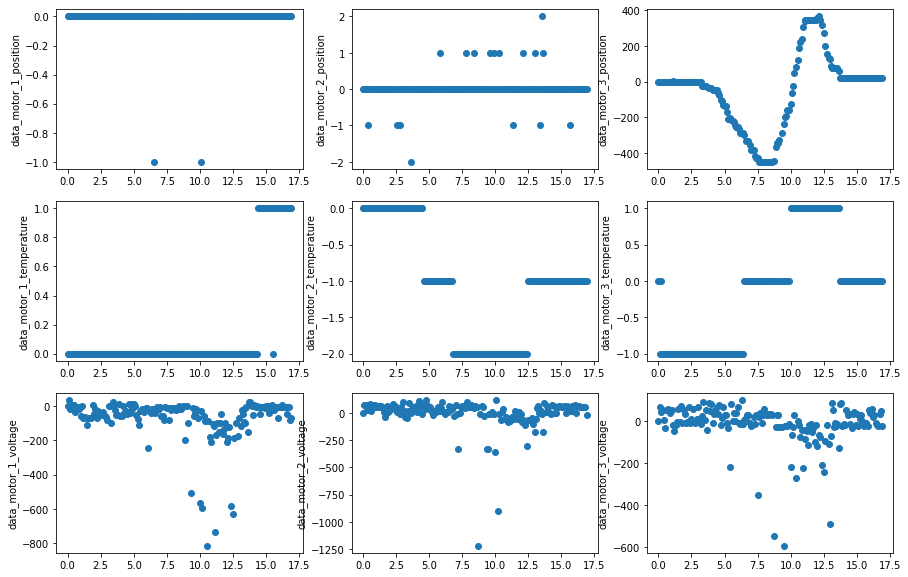

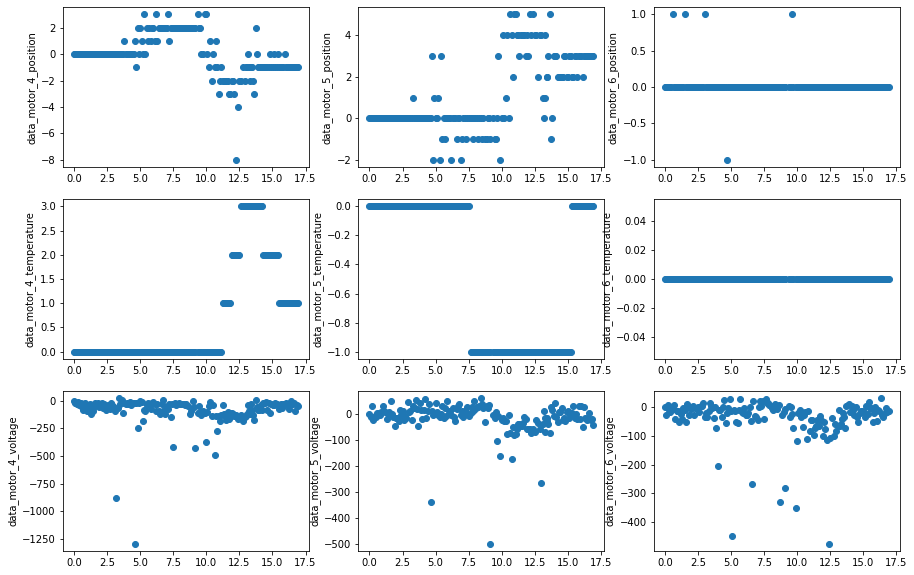

20240503_163963: 19    Pick up and place
Name: Description, dtype: object



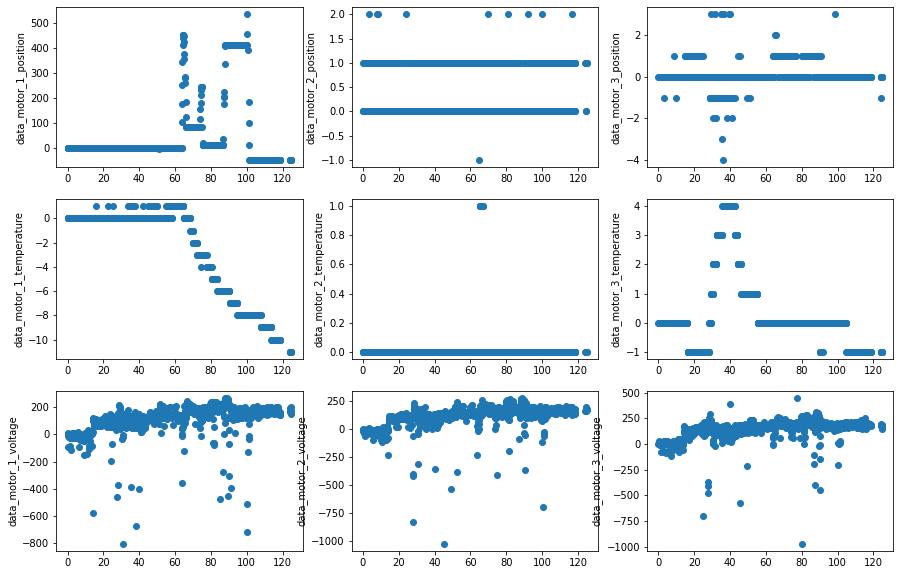

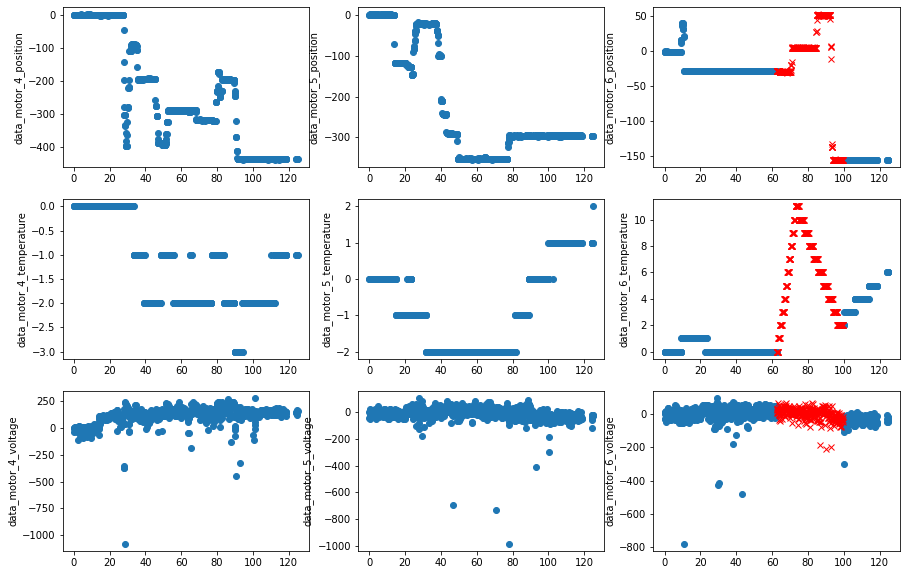

20240503_164435: 20    Turning motor 6
Name: Description, dtype: object



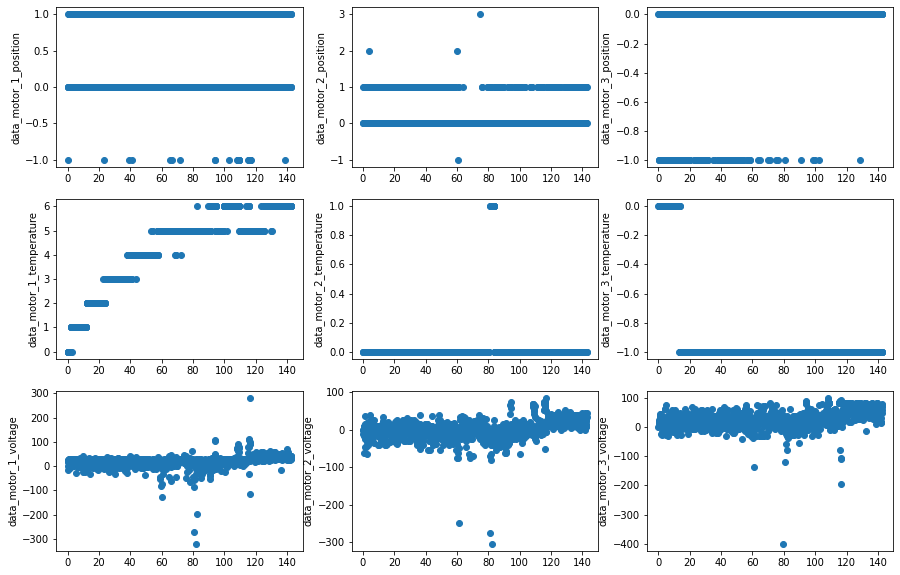

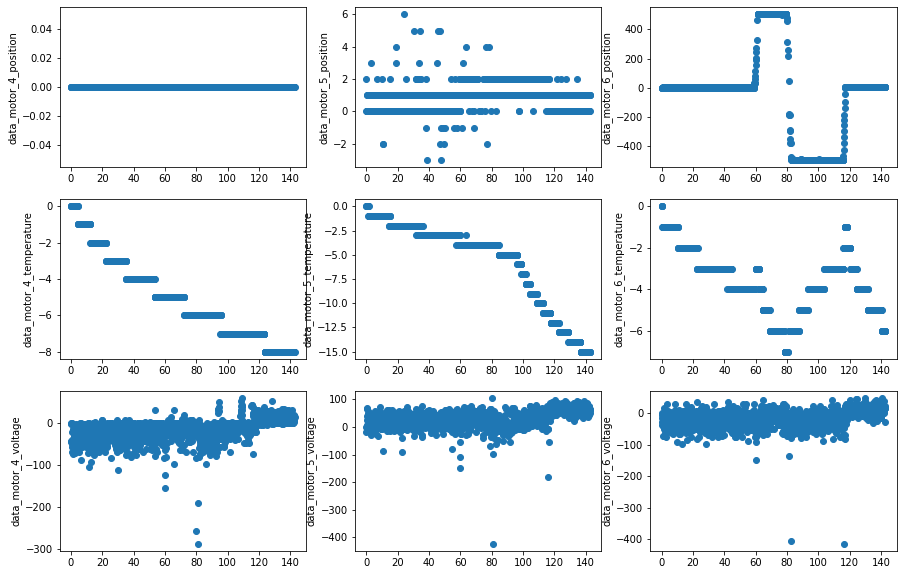

20240503_164675: 21    Turning motor 6
Name: Description, dtype: object



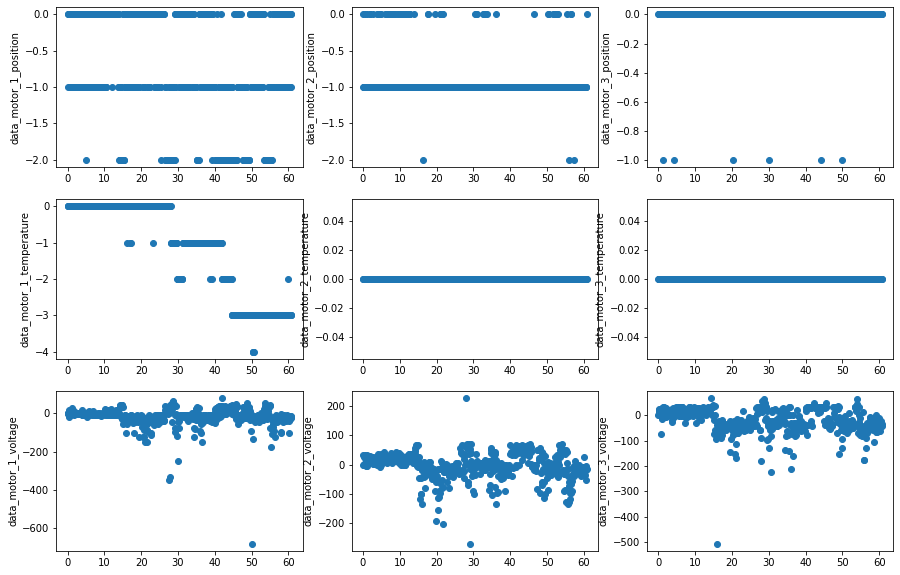

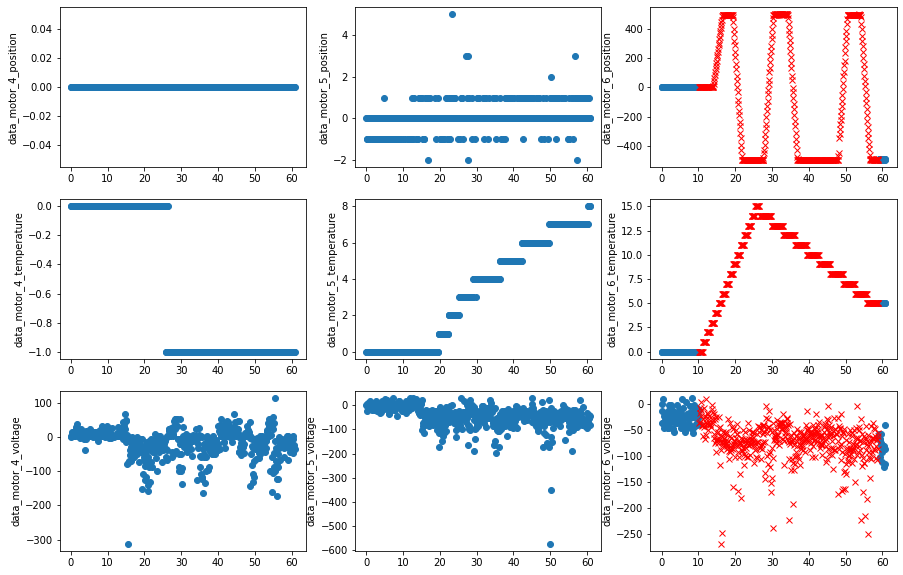

20240503_165189: 22    Turning motor 6
Name: Description, dtype: object



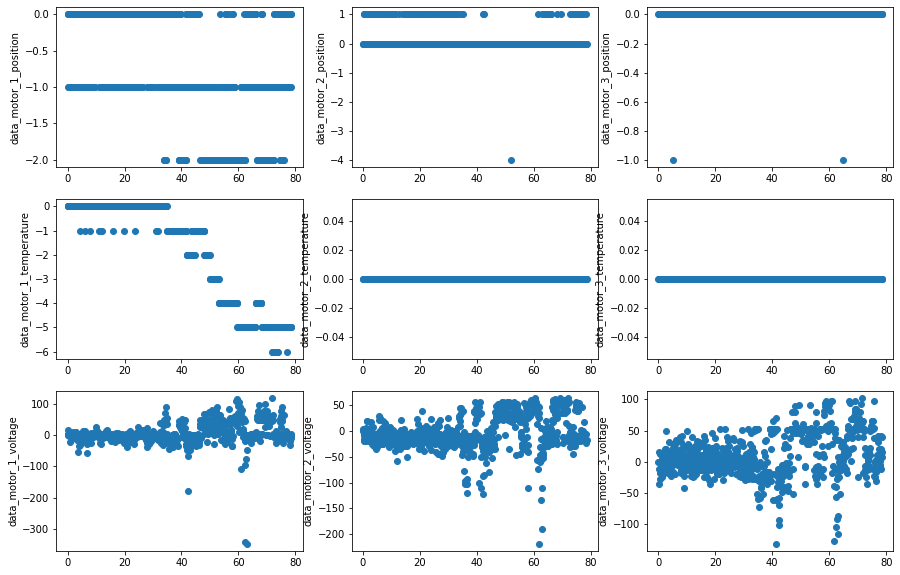

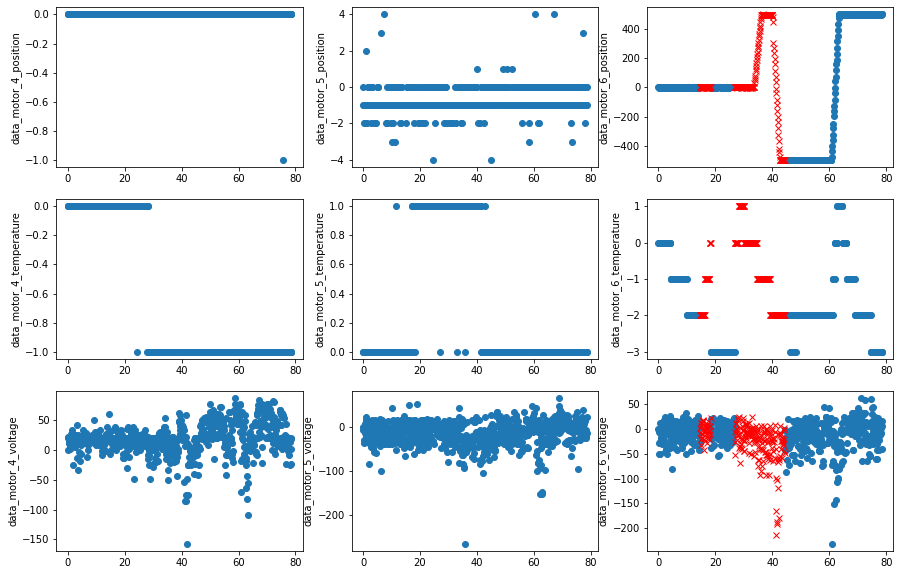

In [2]:
# Ignore warnings.
warnings.filterwarnings('ignore')

# Read all the dataset. Change to your dictionary if needed.
base_dictionary = '../../dataset/training_data/training_data/'
df_train = read_all_test_data_from_path(base_dictionary, pre_processing, is_plot=True)

### Testing data.

20240527_094865: 0    Transfer goods
Name: Description, dtype: object



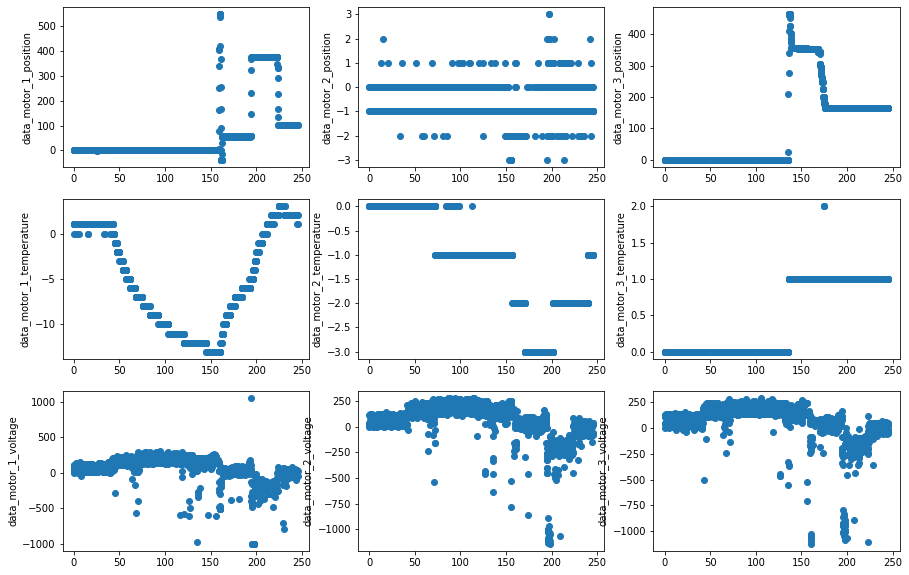

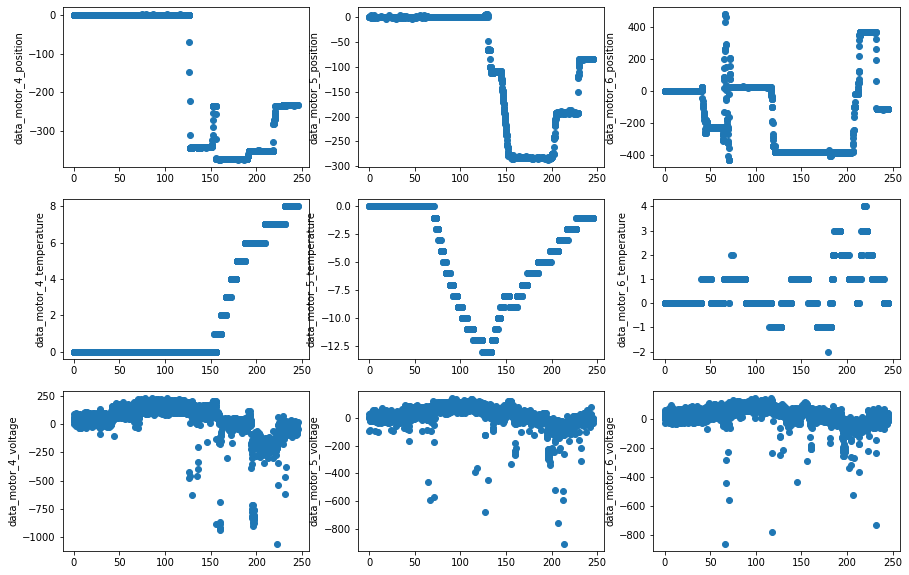

20240527_100759: 1    Transfer goods
Name: Description, dtype: object



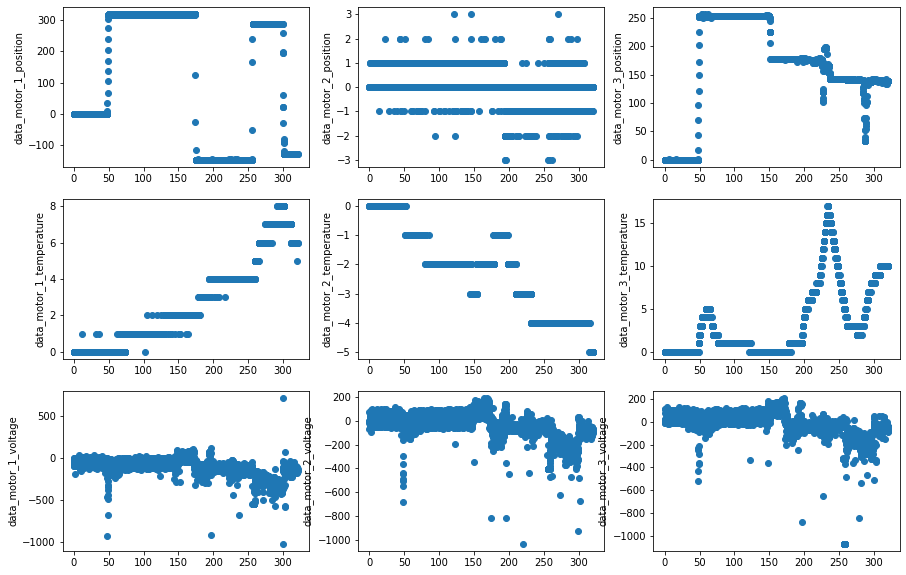

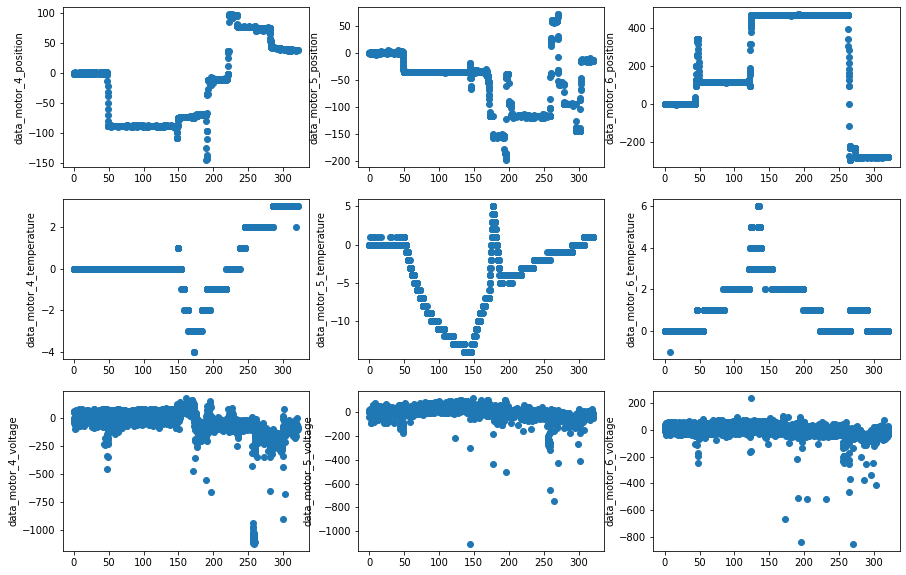

20240527_101627: 2    Transfer goods
Name: Description, dtype: object



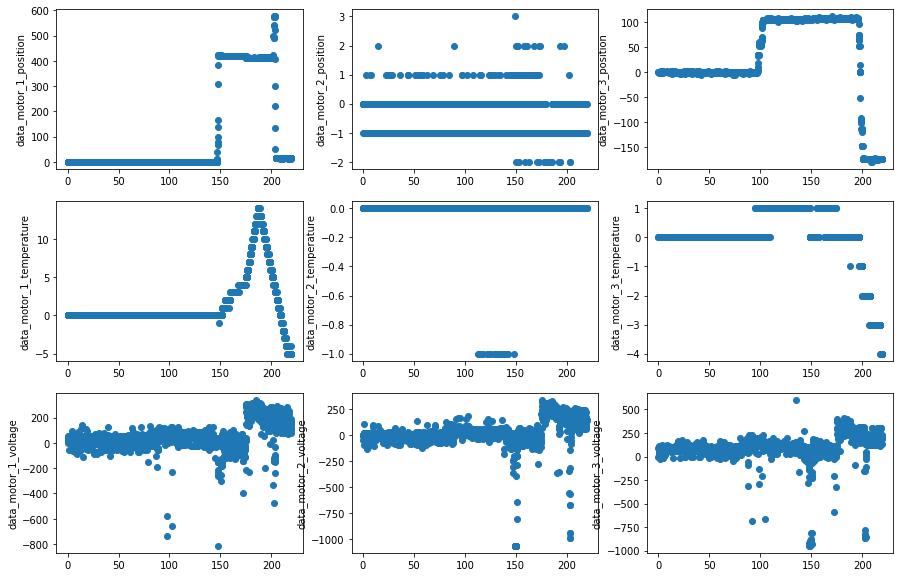

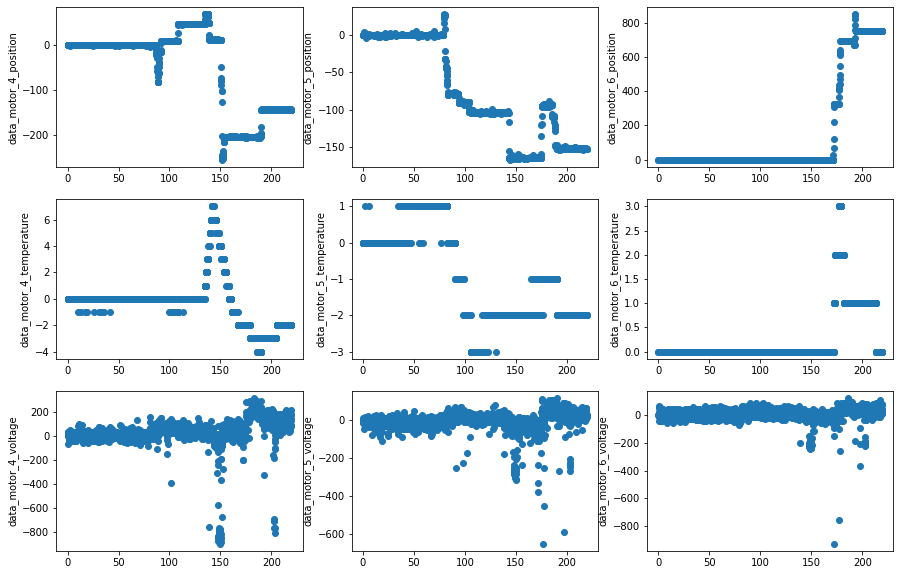

20240527_102436: 3    Not moving
Name: Description, dtype: object



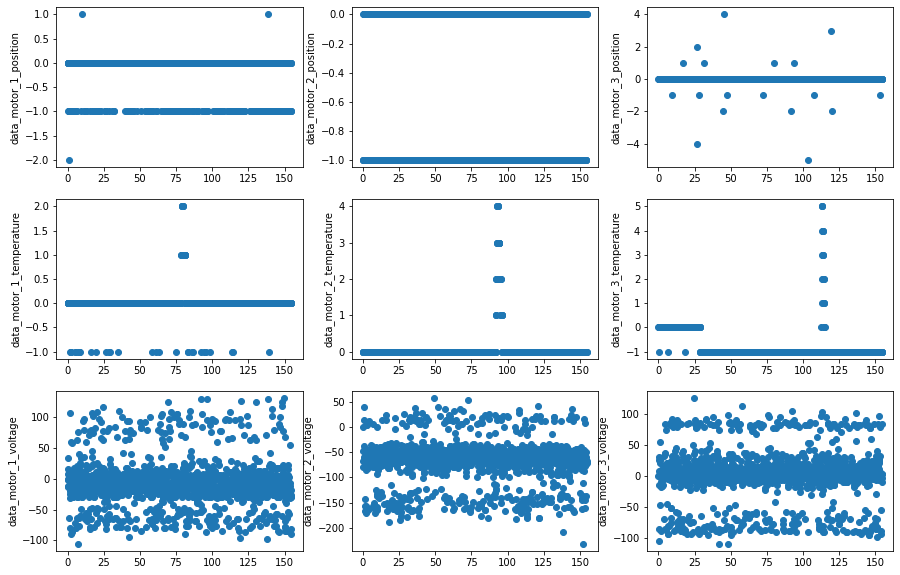

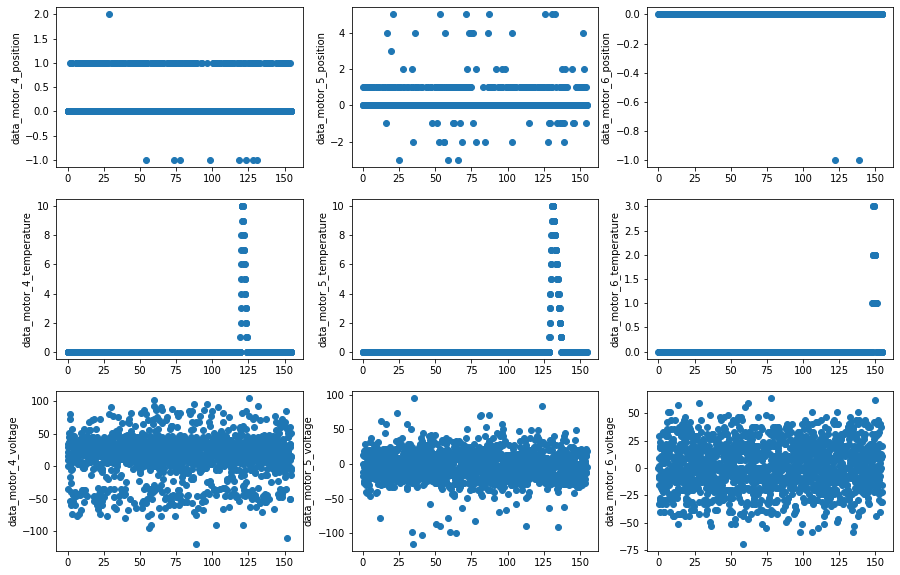

20240527_102919: 4    Not moving
Name: Description, dtype: object



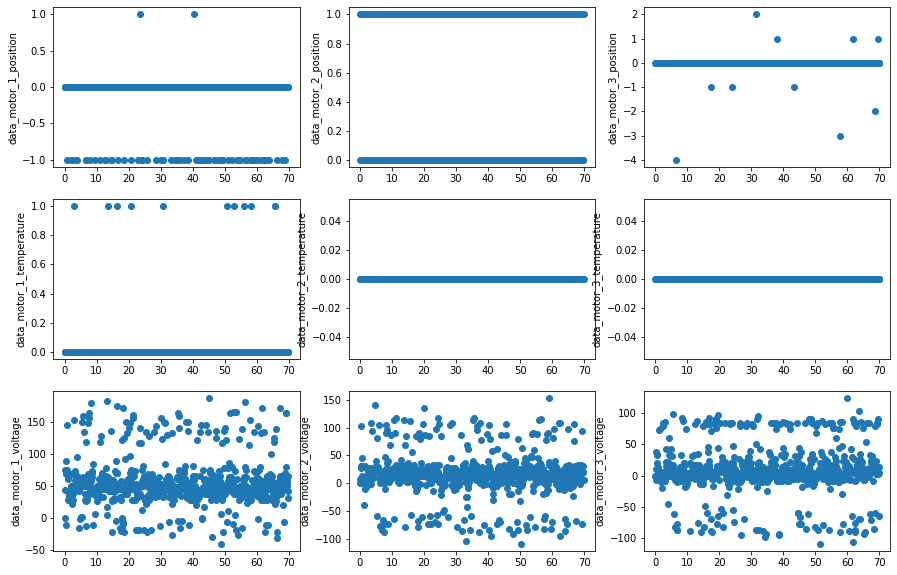

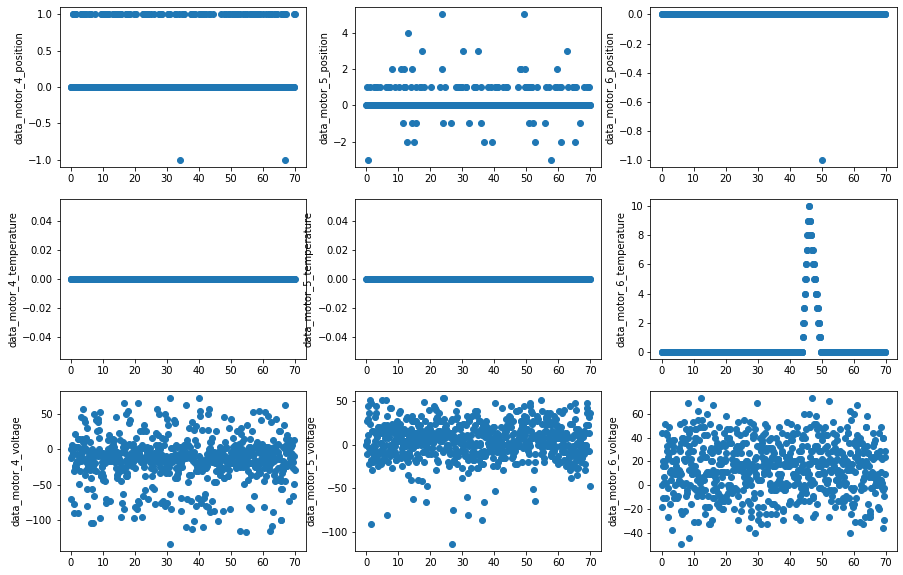

20240527_103311: 5    Not moving
Name: Description, dtype: object



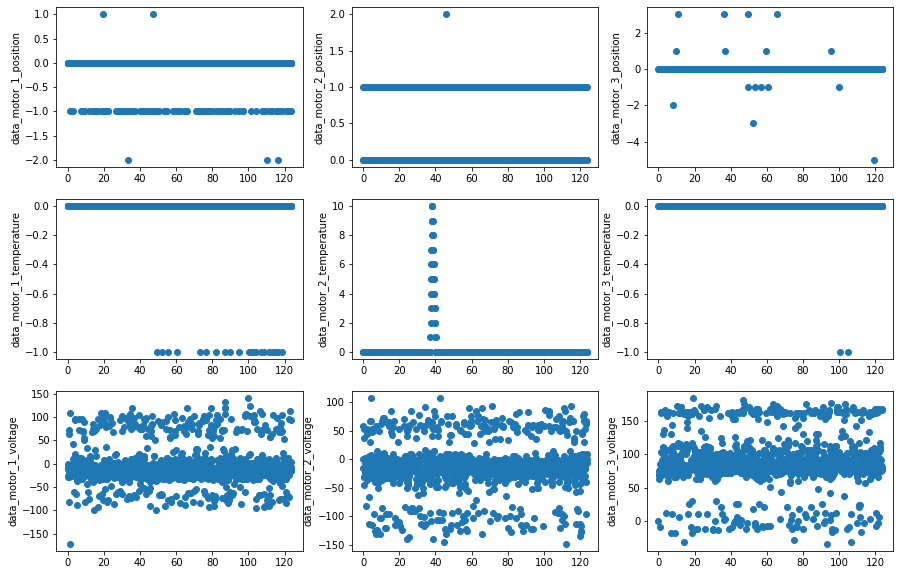

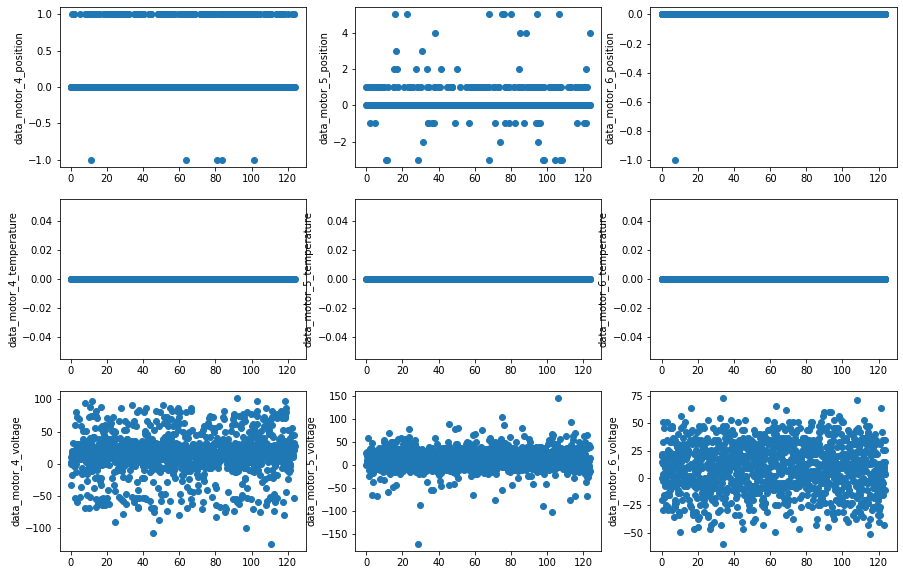

20240527_103690: 6    Moving one motor
Name: Description, dtype: object



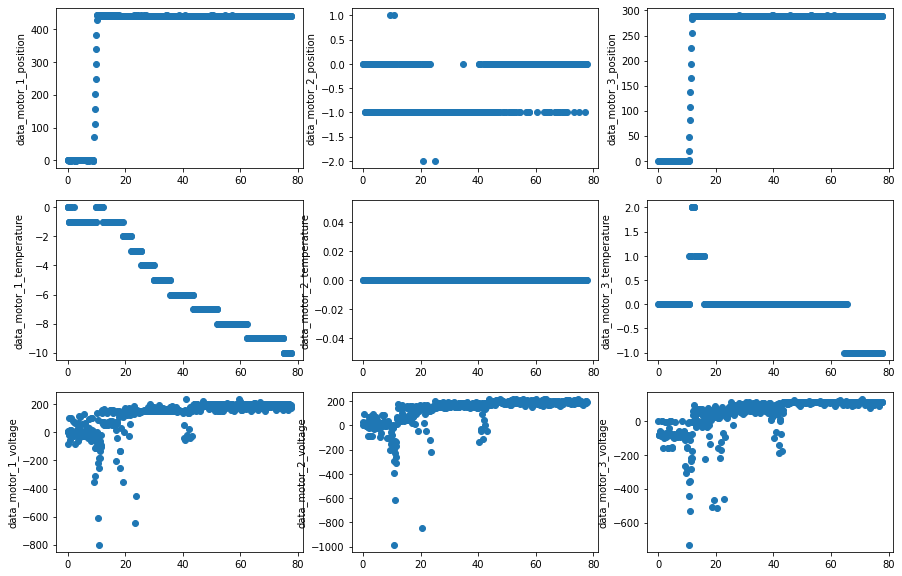

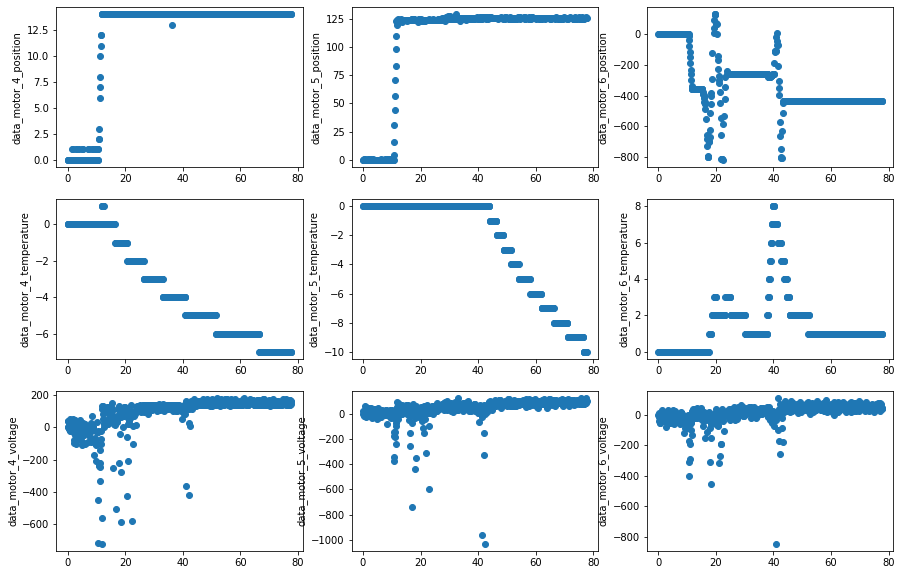

20240527_104247: 7    Moving one motor
Name: Description, dtype: object



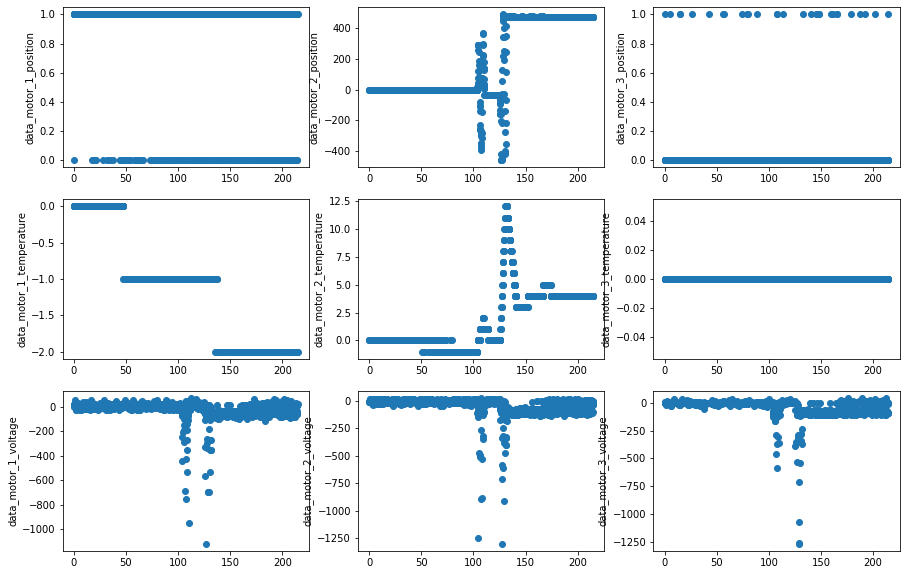

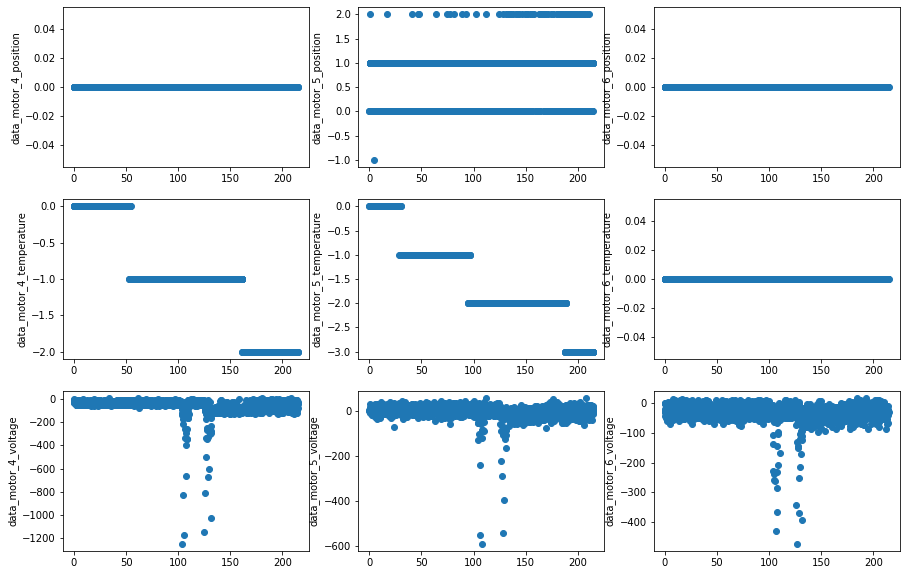

In [3]:
# Read all the dataset. Change to your dictionary if needed.
base_dictionary = '../../dataset/testing_data/testing_data/'
df_test = read_all_test_data_from_path(base_dictionary, pre_processing, is_plot=True)

## Demo: Apply a classification-based fault detection model.

In this section, we use motor $6$ as an example to demonstrate how to train a classification-based fault detection model and apply it to predict the labels on the testing dataset. The basic steps are the same as Workpackage 2. However, you need to pay attention if you use sliding windows to augument the feature space. In this case, the first window_size points in each sequence were scaped in the augumented feature space, as we do not have enough points in the history. In the data challenge, these scaped points need to be predicted manually, as the evaluation is done on all the points, including the scaped points.

In the current version of `prepare_sliding_window`, we addressed this issue by filling the missed history based on the closest available observations in the dataset. Therefore, you just need to make sure you use this version of `utility.py`, the scaped points will be filled automatically.

Below, you can find a demo how to train a logistic regression model to predict the labels for motor 6. For more details on the classification-bsaed fault detection models, you can have a look at the tutorials in [WP2](../../supporting_scripts/WP_2_20240516/demo_motor_6_lr.ipynb).

### Training

In [4]:
# from utility import extract_selected_feature, prepare_sliding_window

# # Define the motor index.
# motor_idx = 3

# # Specify the test conditions you would like to include in the training.
# df_data_experiment = df_train[df_train['test_condition'].isin(['20240425_093699', '20240425_094425', '20240426_140055',
#                                                        '20240503_164675', '20240503_165189',
#                                                        '20240503_163963', '20240325_155003'])]

# # Define the features.
# feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
#                     'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
#                     'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
#                     'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
#                     'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
#                     'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']
# # Extract the features.
# df_tr_x, df_tr_y = extract_selected_feature(df_data_experiment, feature_list_all, motor_idx, mdl_type='clf')

# # Prepare the training data based on the defined sliding window.
# window_size = 50
# sample_step = 10
# X_train, y_train = prepare_sliding_window(df_x=df_tr_x, y=df_tr_y, window_size=window_size, sample_step=sample_step, mdl_type='clf')

# # Define the classification model.
# # Define the steps of the pipeline
# steps = [
#     ('standardizer', StandardScaler()),  # Step 1: StandardScaler
#     ('mdl', LogisticRegression(class_weight='balanced'))    # Step 2: Linear Regression
# ]

# # Create the pipeline
# pipeline = Pipeline(steps)

# # Define hyperparameters to search
# param_grid = {
#     'mdl__C': [0.001, 0.01, 0.1, 1, 10, 100]  # Inverse of regularization strength
# }

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=5)

# # Train the model.
# mdl = grid_search.fit(X_train, y_train)

### Make prediction on the testing dataset.

In [5]:
# # Prepare for the testing dataset.
# # Define the features.
# feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
#                     'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
#                     'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
#                     'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
#                     'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
#                     'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']
# # Add test_condition for extracting different sequences.
# feature_list_all.append('test_condition')
# # Get the features.
# df_test_x = df_test[feature_list_all]
# # Augument the features in the same way as the training data.
# X_test = prepare_sliding_window(df_x=df_test_x, window_size=window_size, sample_step=sample_step, mdl_type='clf')
# # Make prediction.
# y_pred_3_clf = grid_search.predict(X_test)

## Demo: Apply a regression-based fault detection model.

In this section, we will apply a regression-based fault detection model to the data. We choose the motor $5$ as an example. For details on regression-based fault detection, please refer to the tutorials in [WP3](../../supporting_scripts/WP_3_20240521/demo_FaultDetectReg.ipynb).

### Training the regression model.

In [6]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from utility import (
    read_all_test_data_from_path,
    extract_selected_feature,
    prepare_sliding_window,
    FaultDetectReg
)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import warnings

warnings.filterwarnings('ignore')

motor_idx = 3

# 1) Get all the normal data for motor 3
normal_test_id = [
    '20240105_164214','20240105_165300','20240105_165972',
    '20240320_152031','20240320_153841','20240320_155664',
    '20240321_122650','20240325_135213','20240325_152902',
    '20240426_141190','20240426_141532','20240426_141602',
    '20240426_141726','20240426_141938','20240426_141980',
    '20240503_163963','20240503_164435','20240503_164675',
    '20240503_165189'
]
df_tr_motor_3 = df_train[df_train['test_condition'].isin(normal_test_id)].copy()

# ─── Step 1: FEATURE ENGINEERING for Motor 3 ───
df_tr_motor_3['data_motor_3_temperature_roll5'] = (
    df_tr_motor_3
    .groupby('test_condition')['data_motor_3_temperature']
    .rolling(window=5)
    .mean()
    .reset_index(level=0, drop=True)
)
df_tr_motor_3['data_motor_3_temperature_roll5_std'] = (
    df_tr_motor_3
    .groupby('test_condition')['data_motor_3_temperature']
    .rolling(window=5)
    .std()
    .reset_index(level=0, drop=True)
)
df_tr_motor_3['data_motor_3_voltage_roll5'] = (
    df_tr_motor_3
    .groupby('test_condition')['data_motor_3_voltage']
    .rolling(window=5)
    .mean()
    .reset_index(level=0, drop=True)
)
df_tr_motor_3['data_motor_3_voltage_roll5_std'] = (
    df_tr_motor_3
    .groupby('test_condition')['data_motor_3_voltage']
    .rolling(window=5)
    .std()
    .reset_index(level=0, drop=True)
)
df_tr_motor_3['temp3_lag1'] = (
    df_tr_motor_3
    .groupby('test_condition')['data_motor_3_temperature']
    .shift(1)
)

# ─── Impute NaNs generated by the rolling/lag operations ───
df_tr_motor_3.fillna(method='ffill', inplace=True)
df_tr_motor_3.fillna(0, inplace=True)

# 2) Define base features + the new rolling/lag columns
feature_list_all = [
    'time',
    'data_motor_1_position','data_motor_1_temperature','data_motor_1_voltage',
    'data_motor_2_position','data_motor_2_temperature','data_motor_2_voltage',
    'data_motor_3_position','data_motor_3_temperature','data_motor_3_voltage',
    'data_motor_4_position','data_motor_4_temperature','data_motor_4_voltage',
    'data_motor_5_position','data_motor_5_temperature','data_motor_5_voltage',
    'data_motor_6_position','data_motor_6_temperature','data_motor_6_voltage',
    # Added features:
    'data_motor_3_temperature_roll5',
    'data_motor_3_temperature_roll5_std',
    'data_motor_3_voltage_roll5',
    'data_motor_3_voltage_roll5_std',
    'temp3_lag1'
]

# 3) Extract features/labels for regression
x_tr_org, y_temp_tr_org = extract_selected_feature(
    df_data=df_tr_motor_3,
    feature_list=feature_list_all,
    motor_idx=motor_idx,
    mdl_type='reg'
)

# 4) Sliding‐window
window_size = 2
sample_step = 1
prediction_lead_time = 1
threshold = 1
abnormal_limit = 3

x_tr, y_temp_tr = prepare_sliding_window(
    df_x=x_tr_org,
    y=y_temp_tr_org,
    window_size=window_size,
    sample_step=sample_step,
    prediction_lead_time=prediction_lead_time,
    mdl_type='reg'
)

print(f"Training data shape: {x_tr.shape}  |  Target shape: {y_temp_tr.shape}")

# 5) Define & train the ensemble (no early stopping)
class EnhancedFaultDetector:
    def __init__(self, threshold=0.85, abnormal_limit=5, window_size=20,
                 sample_step=1, pred_lead_time=1):
        self.threshold = threshold
        self.abnormal_limit = abnormal_limit
        self.window_size = window_size
        self.sample_step = sample_step
        self.pred_lead_time = pred_lead_time
        self.models = {}
        self.scalers = {}

    def train_ensemble(self, x_tr, y_temp_tr):
        """Train XGBoost, RF, and GB, then store in self.models"""

        # ——— Model 1: XGBoost (fewer trees, no early stopping) ———
        print("Training XGBoost model...")
        self.scalers['xgb'] = RobustScaler()
        x_tr_scaled_xgb = self.scalers['xgb'].fit_transform(x_tr)

        self.models['xgb'] = xgb.XGBRegressor(
            n_estimators=100,   # smaller to avoid long train
            max_depth=6,
            learning_rate=0.05,
            subsample=0.85,
            colsample_bytree=0.85,
            reg_alpha=0.1,
            reg_lambda=0.1,
            random_state=42,
            n_jobs=-1,
            verbosity=0
        )
        self.models['xgb'].fit(x_tr_scaled_xgb, y_temp_tr)

        # ——— Model 2: Random Forest ———
        print("Training Random Forest model...")
        self.scalers['rf'] = StandardScaler()
        x_tr_scaled_rf = self.scalers['rf'].fit_transform(x_tr)

        self.models['rf'] = RandomForestRegressor(
            n_estimators=300,
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1
        )
        
        
        self.models['rf'].fit(x_tr_scaled_rf, y_temp_tr)

#         # ——— Model 3: Gradient Boosting ———
#         print("Training Gradient Boosting model...")
#         self.scalers['gb'] = StandardScaler()
#         x_tr_scaled_gb = self.scalers['gb'].fit_transform(x_tr)

#         self.models['gb'] = GradientBoostingRegressor(
#             n_estimators=100,
#             max_depth=8,
#             learning_rate=0.1,
#             subsample=0.8,
#             random_state=42
#         )
#         self.models['gb'].fit(x_tr_scaled_gb, y_temp_tr)

        print("Ensemble training completed!")

    def predict_ensemble(self, x_test):
        """Ensemble‐average predictions from each model"""
        preds = []

        # XGBoost
        x_test_scaled_xgb = self.scalers['xgb'].transform(x_test)
        preds.append(self.models['xgb'].predict(x_test_scaled_xgb))

        # Random Forest
        x_test_scaled_rf = self.scalers['rf'].transform(x_test)
        preds.append(self.models['rf'].predict(x_test_scaled_rf))

#         # Gradient Boosting
#         x_test_scaled_gb = self.scalers['gb'].transform(x_test)
#         preds.append(self.models['gb'].predict(x_test_scaled_gb))

#         weights = [0.4, 0.3, 0.3]
        # random forest is the best
        weights = [0, 1]
        ensemble_pred = np.average(preds, axis=0, weights=weights)
        return ensemble_pred

    def predict(self, df_x_test, y_response_test, complement_truncation=True):
        """Generate binary fault + continuous temp predictions (unchanged)"""
        x_test, y_test = prepare_sliding_window(
            df_x=df_x_test,
            y=y_response_test,
            window_size=self.window_size,
            sample_step=self.sample_step,
            prediction_lead_time=self.pred_lead_time,
            mdl_type='reg'
        )
        y_pred_temp = self.predict_ensemble(x_test)
        residuals = np.abs(y_test - y_pred_temp)

        resid_mean = np.mean(residuals)
        resid_std = np.std(residuals)
        adaptive_threshold = resid_mean + 2 * resid_std
        final_threshold = min(self.threshold, adaptive_threshold)

        fault_ind = residuals > final_threshold
        fault_smooth = pd.Series(fault_ind).rolling(window=3, center=True).mean() > 0.5
        y_pred_fault = fault_smooth.astype(int).values

        if complement_truncation and len(y_pred_fault) < len(y_response_test):
            padding = len(y_response_test) - len(y_pred_fault)
            y_pred_fault = np.concatenate([np.zeros(padding), y_pred_fault])

        return y_pred_fault, y_pred_temp

print("Training enhanced ensemble model...")
enhanced_detector = EnhancedFaultDetector(
    threshold=threshold,
    abnormal_limit=abnormal_limit,
    window_size=window_size,
    sample_step=sample_step,
    pred_lead_time=prediction_lead_time
)
enhanced_detector.train_ensemble(x_tr, y_temp_tr)


# ─── TEST‐SIDE FEATURE ENGINEERING + PREDICTION ───

# Apply rolling & lag FE to df_test for Motor 3 (mirror Chunk 1)
df_test['data_motor_3_temperature_roll5'] = (
    df_test
    .groupby('test_condition')['data_motor_3_temperature']
    .rolling(window=5)
    .mean()
    .reset_index(level=0, drop=True)
)
df_test['data_motor_3_temperature_roll5_std'] = (
    df_test
    .groupby('test_condition')['data_motor_3_temperature']
    .rolling(window=5)
    .std()
    .reset_index(level=0, drop=True)
)
df_test['data_motor_3_voltage_roll5'] = (
    df_test
    .groupby('test_condition')['data_motor_3_voltage']
    .rolling(window=5)
    .mean()
    .reset_index(level=0, drop=True)
)
df_test['data_motor_3_voltage_roll5_std'] = (
    df_test
    .groupby('test_condition')['data_motor_3_voltage']
    .rolling(window=5)
    .std()
    .reset_index(level=0, drop=True)
)
df_test['temp3_lag1'] = (
    df_test
    .groupby('test_condition')['data_motor_3_temperature']
    .shift(1)
)

# ─── Impute NaNs in df_test the same way ───
df_test.fillna(method='ffill', inplace=True)
df_test.fillna(0, inplace=True)

# Extract engineered features & “true” y for sliding windows
x_test_org, y_temp_test_org = extract_selected_feature(
    df_data=df_test,
    feature_list=feature_list_all,  # includes rolling/lag columns
    motor_idx=motor_idx,
    mdl_type='reg'
)

# Create sliding‐window test set
X_test, y_test_windows = prepare_sliding_window(
    df_x=x_test_org,
    y=y_temp_test_org,
    window_size=window_size,
    sample_step=sample_step,
    mdl_type='reg'
)

# Predict using the trained ensemble
print("Making predictions on Motor 3 test set...")
y_pred_3_enhanced, y_response_test_pred_enhanced = enhanced_detector.predict(
    df_x_test=x_test_org,
    y_response_test=y_temp_test_org,
    complement_truncation=True
)

# Optional: Evaluate continuous‐temperature error
from sklearn.metrics import mean_squared_error, mean_absolute_error

if len(y_response_test_pred_enhanced) > 0:
    mse = mean_squared_error(
        y_temp_test_org[:len(y_response_test_pred_enhanced)],
        y_response_test_pred_enhanced
    )
    mae = mean_absolute_error(
        y_temp_test_org[:len(y_response_test_pred_enhanced)],
        y_response_test_pred_enhanced
    )
    print(f"Temperature MSE: {mse:.6f}, MAE: {mae:.6f}")

print(f"Number of fault detections: {np.sum(y_pred_3_enhanced)}")
print(f"Fault detection rate: {np.mean(y_pred_3_enhanced):.4f}")



Training data shape: (30822, 47)  |  Target shape: (30822,)
Training enhanced ensemble model...
Training XGBoost model...
Training Random Forest model...
Ensemble training completed!
Making predictions on Motor 3 test set...
Temperature MSE: 0.081556, MAE: 0.048370
Number of fault detections: 251
Fault detection rate: 0.0177


In [7]:
# Add this code after your existing model training and prediction sections
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("="*60)
print("DETAILED RMSE METRICS FOR MOTOR 3 ENSEMBLE MODEL")
print("="*60)

# 1. RMSE for individual models on training data
print("\n1. INDIVIDUAL MODEL PERFORMANCE ON TRAINING DATA:")
print("-"*50)

# Get training predictions from each model
x_tr_scaled_xgb = enhanced_detector.scalers['xgb'].transform(x_tr)
y_pred_train_xgb = enhanced_detector.models['xgb'].predict(x_tr_scaled_xgb)

x_tr_scaled_rf = enhanced_detector.scalers['rf'].transform(x_tr)
y_pred_train_rf = enhanced_detector.models['rf'].predict(x_tr_scaled_rf)

# x_tr_scaled_gb = enhanced_detector.scalers['gb'].transform(x_tr)
# y_pred_train_gb = enhanced_detector.models['gb'].predict(x_tr_scaled_gb)

# Ensemble prediction on training data
y_pred_train_ensemble = enhanced_detector.predict_ensemble(x_tr)

# Calculate RMSE for each model on training data
rmse_train_xgb = np.sqrt(mean_squared_error(y_temp_tr, y_pred_train_xgb))
rmse_train_rf = np.sqrt(mean_squared_error(y_temp_tr, y_pred_train_rf))
# rmse_train_gb = np.sqrt(mean_squared_error(y_temp_tr, y_pred_train_gb))
rmse_train_ensemble = np.sqrt(mean_squared_error(y_temp_tr, y_pred_train_ensemble))

print(f"XGBoost RMSE (Train):      {rmse_train_xgb:.6f}")
print(f"Random Forest RMSE (Train): {rmse_train_rf:.6f}")
# print(f"Gradient Boost RMSE (Train): {rmse_train_gb:.6f}")
print(f"Ensemble RMSE (Train):     {rmse_train_ensemble:.6f}")

# 2. RMSE for test data (sliding window predictions)
print("\n2. MODEL PERFORMANCE ON TEST DATA (SLIDING WINDOW):")
print("-"*50)

# Get individual model predictions on test data
y_pred_test_xgb = enhanced_detector.models['xgb'].predict(
    enhanced_detector.scalers['xgb'].transform(X_test)
)
y_pred_test_rf = enhanced_detector.models['rf'].predict(
    enhanced_detector.scalers['rf'].transform(X_test)
)
# y_pred_test_gb = enhanced_detector.models['gb'].predict(
#     enhanced_detector.scalers['gb'].transform(X_test)
# )
y_pred_test_ensemble = enhanced_detector.predict_ensemble(X_test)

# Calculate RMSE for each model on test data
rmse_test_xgb = np.sqrt(mean_squared_error(y_test_windows, y_pred_test_xgb))
rmse_test_rf = np.sqrt(mean_squared_error(y_test_windows, y_pred_test_rf))
# rmse_test_gb = np.sqrt(mean_squared_error(y_test_windows, y_pred_test_gb))
rmse_test_ensemble = np.sqrt(mean_squared_error(y_test_windows, y_pred_test_ensemble))

print(f"XGBoost RMSE (Test):       {rmse_test_xgb:.6f}")
print(f"Random Forest RMSE (Test):  {rmse_test_rf:.6f}")
# print(f"Gradient Boost RMSE (Test): {rmse_test_gb:.6f}")
print(f"Ensemble RMSE (Test):      {rmse_test_ensemble:.6f}")

# 3. Additional metrics for ensemble model
print("\n3. COMPREHENSIVE METRICS FOR ENSEMBLE MODEL:")
print("-"*50)

# Training metrics
mae_train = mean_absolute_error(y_temp_tr, y_pred_train_ensemble)
r2_train = r2_score(y_temp_tr, y_pred_train_ensemble)

# Test metrics  
mae_test = mean_absolute_error(y_test_windows, y_pred_test_ensemble)
r2_test = r2_score(y_test_windows, y_pred_test_ensemble)

print("TRAINING SET:")
print(f"  RMSE: {rmse_train_ensemble:.6f}")
print(f"  MAE:  {mae_train:.6f}")
print(f"  R²:   {r2_train:.6f}")

print("\nTEST SET:")
print(f"  RMSE: {rmse_test_ensemble:.6f}")
print(f"  MAE:  {mae_test:.6f}")
print(f"  R²:   {r2_test:.6f}")

# 4. Model improvement analysis
print("\n4. MODEL IMPROVEMENT ANALYSIS:")
print("-"*50)

best_individual_test = min(rmse_test_xgb, rmse_test_rf)
improvement = ((best_individual_test - rmse_test_ensemble) / best_individual_test) * 100

print(f"Best individual model RMSE: {best_individual_test:.6f}")
print(f"Ensemble RMSE:              {rmse_test_ensemble:.6f}")
print(f"Improvement from ensemble:  {improvement:.2f}%")

# 5. Overfitting analysis
print("\n5. OVERFITTING ANALYSIS:")
print("-"*50)

overfitting_xgb = ((rmse_test_xgb - rmse_train_xgb) / rmse_train_xgb) * 100
overfitting_rf = ((rmse_test_rf - rmse_train_rf) / rmse_train_rf) * 100
# overfitting_gb = ((rmse_test_gb - rmse_train_gb) / rmse_train_gb) * 100
overfitting_ensemble = ((rmse_test_ensemble - rmse_train_ensemble) / rmse_train_ensemble) * 100

print(f"XGBoost overfitting:      {overfitting_xgb:.2f}%")
print(f"Random Forest overfitting: {overfitting_rf:.2f}%")
# print(f"Gradient Boost overfitting: {overfitting_gb:.2f}%")
print(f"Ensemble overfitting:     {overfitting_ensemble:.2f}%")

# 6. Residual analysis
print("\n6. RESIDUAL ANALYSIS:")
print("-"*50)

residuals_test = y_test_windows - y_pred_test_ensemble
residual_std = np.std(residuals_test)
residual_mean = np.mean(residuals_test)

print(f"Residual mean:     {residual_mean:.6f}")
print(f"Residual std:      {residual_std:.6f}")
print(f"Residual min:      {np.min(residuals_test):.6f}")
print(f"Residual max:      {np.max(residuals_test):.6f}")

# 7. Temperature range analysis
print("\n7. TEMPERATURE RANGE ANALYSIS:")
print("-"*50)

temp_range_actual = np.max(y_test_windows) - np.min(y_test_windows)
temp_range_pred = np.max(y_pred_test_ensemble) - np.min(y_pred_test_ensemble)

print(f"Actual temperature range:    {temp_range_actual:.6f}")
print(f"Predicted temperature range: {temp_range_pred:.6f}")
print(f"Range capture ratio:         {(temp_range_pred/temp_range_actual)*100:.2f}%")

print("\n" + "="*60)
print("RMSE ANALYSIS COMPLETE")
print("="*60)

DETAILED RMSE METRICS FOR MOTOR 3 ENSEMBLE MODEL

1. INDIVIDUAL MODEL PERFORMANCE ON TRAINING DATA:
--------------------------------------------------
XGBoost RMSE (Train):      0.041451
Random Forest RMSE (Train): 0.028413
Ensemble RMSE (Train):     0.028413

2. MODEL PERFORMANCE ON TEST DATA (SLIDING WINDOW):
--------------------------------------------------
XGBoost RMSE (Test):       0.259980
Random Forest RMSE (Test):  0.285580
Ensemble RMSE (Test):      0.285580

3. COMPREHENSIVE METRICS FOR ENSEMBLE MODEL:
--------------------------------------------------
TRAINING SET:
  RMSE: 0.028413
  MAE:  0.002883
  R²:   0.999963

TEST SET:
  RMSE: 0.285580
  MAE:  0.048370
  R²:   0.987058

4. MODEL IMPROVEMENT ANALYSIS:
--------------------------------------------------
Best individual model RMSE: 0.259980
Ensemble RMSE:              0.285580
Improvement from ensemble:  -9.85%

5. OVERFITTING ANALYSIS:
--------------------------------------------------
XGBoost overfitting:      527.20%


### Making prediction.

In [8]:
# # Define the fault detector.
# detector_reg = FaultDetectReg(reg_mdl=mdl, threshold=threshold, abnormal_limit=abnormal_limit, window_size=window_size, sample_step=sample_step, pred_lead_time=prediction_lead_time)

# # Define the features.
# feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
#                     'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
#                     'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
#                     'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
#                     'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
#                     'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']
# # Prepare the testing data.
# x_test_org, y_temp_test_org = extract_selected_feature(df_data=df_test, feature_list=feature_list_all, motor_idx=3, mdl_type='reg')

# # Make predicition.
# y_pred_3_reg, y_response_test_pred = detector_reg.predict(df_x_test=x_test_org, y_response_test=y_temp_test_org, complement_truncation=True)

## Prepare the results as a submission file for the data challenge.

In this section, we demo how to prepare the results as a submission file for the data challenge. First, we need to download the submission template `sample_submission.csv` from [kaggle](https://www.kaggle.com/competitions/robot-predictive-maintenance/data). As shown below, in this csv files, we just need to give our prediction on the six motors in the corresponding columns. You can find a demo below.

In [9]:
import pandas as pd

# Read the template.
path = '../kaggle_data_challenge/sample_submission.csv' # Change to your path.
df_submission = pd.read_csv(path)

# Initial all values with -1.
df_submission.loc[:, ['data_motor_1_label', 'data_motor_2_label', 'data_motor_3_label', 'data_motor_4_label', 'data_motor_5_label', 'data_motor_6_label']] = -1
df_submission.head()

idx  data_motor_1_label  data_motor_2_label  data_motor_3_label  \
0    0                  -1                  -1                  -1   
1    1                  -1                  -1                  -1   
2    2                  -1                  -1                  -1   
3    3                  -1                  -1                  -1   
4    4                  -1                  -1                  -1   

   data_motor_4_label  data_motor_5_label  data_motor_6_label   test_condition  
0                  -1                  -1                  -1  20240527_094865  
1                  -1                  -1                  -1  20240527_094865  
2                  -1                  -1                  -1  20240527_094865  
3                  -1                  -1                  -1  20240527_094865  
4                  -1                  -1                  -1  20240527_094865

In [10]:
# Replace each column with your prediction.

df_submission['data_motor_3_label'] = y_pred_3_enhanced
# df_submission['data_motor_3_label'] = y_pred_3_clf

#or df_submission['data_motor_3_label'] = y_pred_3_reg
# For the other motors, we just fill with 0.
df_submission.loc[:, ['data_motor_1_label', 'data_motor_2_label', 'data_motor_4_label','data_motor_5_label','data_motor_6_label']] = -1

In [11]:
df_submission.head()

idx  data_motor_1_label  data_motor_2_label  data_motor_3_label  \
0    0                  -1                  -1                   0   
1    1                  -1                  -1                   0   
2    2                  -1                  -1                   0   
3    3                  -1                  -1                   0   
4    4                  -1                  -1                   0   

   data_motor_4_label  data_motor_5_label  data_motor_6_label   test_condition  
0                  -1                  -1                  -1  20240527_094865  
1                  -1                  -1                  -1  20240527_094865  
2                  -1                  -1                  -1  20240527_094865  
3                  -1                  -1                  -1  20240527_094865  
4                  -1                  -1                  -1  20240527_094865

In [12]:
# Output the submission csv.
df_submission.to_csv('../ws_prepare_data_challenge/submission.csv')